In [1]:
import os
import sys
sys.path.append('/home/kevinteng/Desktop/DE_Project')
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from coord_conv import CoordConv
import cv2
import utils
import utils_vis
import utils_model
from sklearn.model_selection import train_test_split
from utils_vis import plot_comparison
from matplotlib.colors import LinearSegmentedColormap, BoundaryNorm
from random import randint, seed
from utils import stack4plot, similarity_multi, similarity_multiplication
from utils_vis import overlapMasks, overlapMasks02

/home/kevinteng/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/kevinteng/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/kevinteng/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/kevinteng/anaconda3/lib/python3.6/site-package

---------------------

# Retrieving and Preprocess Data

Image size:  100


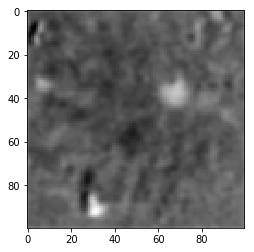

In [2]:
dataset = np.load('/home/kevinteng/Desktop/jpg_to_npy_benchmark/DG13_3-8-17_preprocessed_dF.npy')

#hyperparameter 
NEW_SIZE = 100
ver = 'fullSess04' #version no.
BATCH_SIZE = 8
lr01 = 0.00001 #learning rate for global 
lr02 = 0.000001 #learning rate for encoder 
lr03 = 0.1 #learning rate for learnable coords
n_neurons = 100
MAX_EPOCHS = 1000
l1_coeff = 0.1
thr = 0.3 #threshold for one hot pixel* sim score
dr = 0.4 #dropout rate
pre_pad_type = "SYMMETRIC"
path_desktop = '/home/kevinteng/Desktop/'
#re_list = dataset
re_list = utils.resize(dataset, NEW_SIZE)
IMG_SIZE = re_list.shape[1]

print('Image size: ', IMG_SIZE)
#Dimension for network should include the color channel 
re_list = np.expand_dims(re_list, axis = -1)
#Cast data type to float32 for TensorFlow
# re_list = re_list.astype('float32')
re_list = tf.convert_to_tensor(re_list, dtype = tf.float32)

for img in re_list:
    plt.imshow(np.reshape(img, (IMG_SIZE, IMG_SIZE)), cmap = 'gray')
    plt.show()   
    break
    

In [3]:
#apply min max norm for mean image
re_list = utils.min_max_norm(re_list)
#max_img_ori = np.expand_dims(max_img_ori, -1)
print('Max value:', np.max(re_list))
print('Min value:', np.min(re_list))


Max value: 1.0
Min value: 0.0


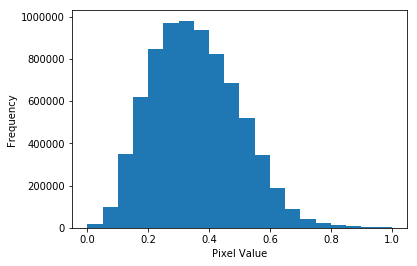

In [4]:
#plot historgram for min max norm image
plt.hist(tf.reshape(re_list, [-1]),20,[0,1])
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.show()

----------------------------------------------------------


# Validation

In [5]:
coords,_, ori_one_hot_imgs = utils_model.create_dat_samples(n_neurons, IMG_SIZE, min_range = 5, 
                                                            max_range = 95, Range = True)
#reshape
coords = tf.reshape(coords, [n_neurons, 1,1,2])
tf.print(tf.shape(coords))

[100 1 1 2]


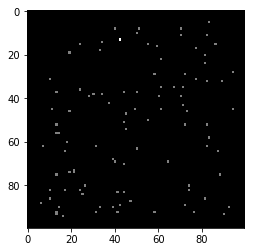

In [6]:
plt.imshow(np.squeeze(np.sum(ori_one_hot_imgs, axis=0)), cmap = 'gray')

-----------------------------------

# Model

In [3]:
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, MaxPooling2D, UpSampling2D
from tensorflow.keras.layers import InputLayer, Conv2DTranspose, Activation, BatchNormalization
from tensorflow.keras.layers import Input, Softmax, Dropout
from tensorflow.keras.regularizers import l1
from utils_model import conv_block, coordconv_block, up_block, up_coord_block
from tensorflow.keras import layers    
    
def encoder(inps, img_size):
    #activity_regularizer=l1(0.1)
    #conv block1
    paddings = tf.constant([[0, 0], [1, 1], [1, 1], [0, 0]])
    coord=tf.pad(inps, paddings, "SYMMETRIC")
    coord1 =CoordConv(x_dim = 102, y_dim = 102, with_r = False, 
                       filters = 128,strides=(1,1), kernel_size = 3, padding='valid')(coord)
    
    paddings1 = tf.constant([[0, 0], [1, 1], [1, 1], [0, 0]])    
    coord1=tf.pad(coord1, paddings1, "SYMMETRIC")
    conv1=Conv2D(32, kernel_size = 3,strides=(2,2), padding='valid',activation = 'relu',activity_regularizer=l1(0.1))(coord1)
    conv2=Conv2D(32, kernel_size = 3,strides=(2,2), padding='valid',activation = 'relu',activity_regularizer=l1(0.1))(coord1)
    pool1=tf.keras.layers.Concatenate()([conv1, conv2])
    drop01 = Dropout(0.4)(pool1)
    paddingsp = tf.constant([[0, 0], [1, 1], [1, 1], [0, 0]])    
    coordp=tf.pad(drop01, paddingsp, "SYMMETRIC")

    #conv block2
    conv3=Conv2D(32, kernel_size = 3,strides=(2,2), padding='valid',activation = 'relu',activity_regularizer=l1(0.1))(coordp)
    conv4=Conv2D(32, kernel_size = 3,strides=(2,2), padding='valid',activation = 'relu',activity_regularizer=l1(0.1))(coordp)
    pool2=tf.keras.layers.Concatenate()([conv3, conv4])
    drop02 = Dropout(0.4)(pool2)
    x=tf.keras.backend.resize_images(drop02, height_factor=2, width_factor=2, data_format="channels_last", interpolation='bilinear')
    paddings2 = tf.constant([[0, 0], [1, 1], [1, 1], [0, 0]])
    
    coord2=tf.pad(x, paddings2, "SYMMETRIC")
    coord2 = Conv2D(32, 3, padding = 'valid', activation = 'relu',activity_regularizer=l1(0.1))(coord2)
    #coord2 = Conv2D(32, 3, padding = 'valid', activation = 'relu')(coord2)
    coord2=tf.keras.backend.resize_images(x, height_factor=2, width_factor=2, data_format="channels_last", interpolation='bilinear')
    paddings3 = tf.constant([[0, 0], [1, 1], [1, 1], [0, 0]])
    coord3=tf.pad(coord2, paddings3, "SYMMETRIC")
    x3 = Conv2D(16, 3, padding = 'valid', activation = 'relu',activity_regularizer=l1(0.1))(coord3)
    paddings4 = tf.constant([[0, 0], [1, 1], [1, 1], [0, 0]])
    coord4=tf.pad(x3, paddings4, "SYMMETRIC")
    output = Conv2D(1, 3, padding = 'valid', activation = 'sigmoid',activity_regularizer=l1(0.1))(coord4)
    return output




def de_conv(input_tensor):
    coord01 = CoordConv(x_dim = 100, y_dim = 100, with_r = False, filters = 100,
              kernel_size = 1, padding='same', activation='relu')(input_tensor)
    conv01 = Conv2D(filters = 50, kernel_size = 1, strides = 1, padding = "same", activation = 'relu')(coord01)
    conv02 = Conv2D(filters = 50, kernel_size = 1, strides = 1, padding = "same", activation = 'relu')(conv01)
    conv03 = Conv2D(filters = 100, kernel_size = 1, strides = 1, padding = "same", activation = 'relu')(conv02)
    conv04 = Conv2D(filters = 100, kernel_size = 1, strides = 1, padding = "same", activation = 'relu')(conv03)
    conv05 = Conv2D(filters = 1, kernel_size = 1, strides = 1, padding = "same" )(conv04)
    f1 = Flatten()(conv05)
    output = Softmax(axis = -1)(f1)

    return output

def de_conv02(input_tensor):
    coord01 = CoordConv(x_dim = 100, y_dim = 100, with_r = False, filters = 100,
              kernel_size = 1, padding='same', activation='relu')(input_tensor)
    conv01 = Conv2D(filters = 1, kernel_size = 1, strides = 1, padding = "same" )(coord01)
    f1 = Flatten()(conv01)
    output = Softmax(axis = -1)(f1)
    return output

def latent_space(encoded_imgs, deconv_imgs, coords, batch_size, img_size):
    '''
    This function construct the dot product of the output of an encoder(batch_size, img_size, img_size, 1) 
    with the one hot images generated by decoord-conv(n_neurons, img_size, img_size, 1), which yields
    similarity score (batch_size, n_neurons). Similarity score is then concatenate to the last layer of the 
    input coordinates with the corresponding batch (batch_size, n_neurons, 3)
    
    @encoded_imgs: output images from the encoder
    @deconv_imgs: one hot images generated from the coordinate list 
    @coords: A list of coordinates generated randomly based on the number of neurons
    @batch_size: Batch size of the input image for encoder, to allocate size for writing in loop
    
    return: 
        latent space with dim (batch_size, n_neurons, 3, 1)
    '''
    similarity_score = tf.tensordot(encoded_imgs, deconv_imgs, [[1,2,3],[1,2,3]]) #(batch_size, n_neurons)
#     squeeze_coords = tf.squeeze(coords/(img_size-1)) #coords dim (n_neurons, 1, 1, 2) = > (n_neurons, 2)
    squeeze_coords = tf.squeeze(coords)
    latent = tf.TensorArray(tf.float32, size=0, dynamic_size=True)
    for i in tf.range(batch_size):
        concat = tf.stack((squeeze_coords[:,-2], squeeze_coords[:,-1], similarity_score[i]), axis=-1)    
        latent = latent.write(i, concat) #(batch_size, n_neurons, 3)
    return tf.expand_dims(latent.stack(), axis = -1), similarity_score

def duplicate_batch(inp_img, batch_size):
    '''
    This function duplicate an image with respect to its batch size
    @param inp_img: input image to be duplicated
    @param batch_size: batch size, which is the number of image to be duplicated

    return duplicated images along axis 0, (batch_size, img_size, img_size, 1)
    '''
    inp_img = tf.expand_dims(inp_img, 0)
    m2 = tf.constant([batch_size, 1, 1, 1], tf.int32)  # multiplier for tiling
    duplicate_imgs = tf.tile(inp_img, m2)
    return tf.cast(duplicate_imgs, dtype = tf.float32)

def decoder(latent_dim):
    flat_01 = Flatten()(latent_dim)
    dense_01 = Dense(25*25*32, activation = 'relu')(flat_01)
    dense_01 = Reshape((25,25,32))(dense_01)
    up_01 = up_coord_block(dense_01, up_size = 2, x_dim = 50, y_dim = 50, filters = 64, 
                           kernel_size = 3, strides = 1, padding = 'same', activation = 'relu')
    up_02 = up_block(up_01, up_size = 2, filters = 32, kernel_size = 3,
                            strides = 1, padding = 'same', activation = 'relu')
    output = Conv2D(filters = 1, kernel_size = 3, strides = 1,
                    padding = 'same', activation = None)(up_02)
    return output

class learnable_coords(layers.Layer):
    def __init__(self, coords):
        super(learnable_coords, self).__init__()
        self.learned_coords = tf.Variable((coords), trainable = True)

    def __call__(self, img_size):
        y = self.learned_coords/(img_size-1) #normalize the coordinates
        #clip values so that the values doesnt runs out of the normalized pixel space 
        y = tf.clip_by_value(y, clip_value_min=0.0, clip_value_max=1.0) 
        return y
    
def gaussian_blur(img, kernel_size=3, sigma=0.01):
    def gauss_kernel(channels, kernel_size, sigma):
        ax = tf.range(-kernel_size // 2 + 1.0, kernel_size // 2 + 1.0)
        xx, yy = tf.meshgrid(ax, ax)
        kernel = tf.exp(-(xx ** 2 + yy ** 2) / (2.0 * sigma ** 2))
        kernel = kernel / tf.reduce_sum(kernel)
        kernel = tf.tile(kernel[..., tf.newaxis], [1, 1, channels])
        return kernel

    gaussian_kernel = gauss_kernel(tf.shape(img)[-1], kernel_size, sigma)
    gaussian_kernel = gaussian_kernel[..., tf.newaxis]

    return tf.nn.depthwise_conv2d(img, gaussian_kernel, [1, 1, 1, 1],
                                  padding='SAME', data_format='NHWC')

In [8]:
# def encoder02(inps, img_size):
#     coord01 = CoordConv(x_dim = img_size, y_dim = img_size, with_r = False, 
#                         filters = 256, kernel_size = 3, padding='same',
#                        activity_regularizer=l1(l1_coeff))(inps)
#     leaky01 =tf.keras.layers.ReLU()(coord01)
#     conv01 = Conv2D(filters = 128, kernel_size = 3, strides = 1, padding = "same", 
#                     activation = 'relu',activity_regularizer=l1(l1_coeff))(leaky01 )
#     leaky02 = tf.keras.layers.ReLU()(conv01)
#     output = Conv2D(1, kernel_size = 3,activation = 'sigmoid', 
#                     padding='same',activity_regularizer=l1(l1_coeff))(leaky02 )
#     return output

-----------------------------------------------------------------

## Build Model

In [9]:
#build encoder 
inps = Input(shape=(IMG_SIZE, IMG_SIZE, 1))
encoder_model = Model(inps, encoder(inps, IMG_SIZE))

#build coord model
inp = Input(shape=(100, 100,2)) #(batch_size, img_size, img_size, 2)
de_coordconv = Model(inp, de_conv(inp))
de_coordconv.load_weights("best_class_model100_02.hdf5")

#decoder
latent_dim = Input(shape=(n_neurons, 3, 1))
decoder_model = Model(latent_dim, decoder(latent_dim))

#learnable coords
l_coords = learnable_coords(coords)

## Train Model

--------------------------------------

In [10]:
#optimizer 
opt_global = tf.keras.optimizers.Adam(lr01)
opt_encoded_dummy = tf.keras.optimizers.Adam(lr02)
opt_coords = tf.keras.optimizers.Adam(lr03)
#loss function 
mse = tf.losses.MeanSquaredError()
bxent = tf.keras.losses.BinaryCrossentropy()
msle = tf.keras.losses.MeanSquaredLogarithmicError()

@tf.function
def train_fn(inp_imgs, coords, img_size, batch_size, neuron_multi = False, one_hot_thr = False):
    with tf.GradientTape(persistent=True) as tape:
        #--RHS pipeline (Learnable Coords)--
        #custom layer for updating coordinates
        updated_coords = l_coords(img_size)
        m1 = tf.constant([1,img_size,img_size,1], tf.int32) #multiplier for tiling 
        #tile coordinates (n_neurons, img_size, img_size, 1)
        tile_cd = tf.tile(updated_coords, m1)
        #de-coordconv model
        de_coordconv.trainable = False #freeze de-coordconv
        #one hot images depending on the learnable coordinates
        one_hot_imgs = tf.reshape(de_coordconv(tile_cd),[-1,img_size, img_size, 1]) #(n_neurons, img_size, img_size, 1)
        #one hot images depending on the dummy coordinates 
        dummy_one_hot = ori_one_hot_imgs
        #--LHS pipeline (Encoder Pipeline)--
        #output from encoder (batch_size, img_size, img_size, 1)
#         gaussian_blurr_input_images=gaussian_blur(inp_imgs)
        encoder_output = encoder_model(inp_imgs)
        
        #--Bottle Neck--
        #latent space
        latent, similarity_score = latent_space(encoder_output, one_hot_imgs, updated_coords, batch_size, img_size)#(batch_size, n_neurons, 3, 1)
        #compute the mse between the neurons with the one hot images generated by the deconv
        if neuron_multi==False:
            #sum one hot images for all neurons, (n_neurons, img_size, img_size, 1) => (img_size, img_size, 1)
            one_hot_sum = tf.math.reduce_sum(one_hot_imgs, 0)
            dummy_sum = tf.math.reduce_sum(dummy_one_hot, 0)
            #duplicate summed one_hot_images and compare with encoded output 
            #(img_size, img_size, 1) => (batch_size, img_size, img_size, 1) 
            duplicated_one_hot = duplicate_batch(one_hot_sum, batch_size)
            duplicated_dummy = duplicate_batch(dummy_sum, batch_size)
            #loss between the encoded output and the one hot images 
            encoded_one_loss = bxent(encoder_output, duplicated_one_hot)
            #loss between the encoded output and the dummy one hot images
            encoded_dummy = bxent(encoder_output, duplicated_dummy)
        #compute the mse between the neurons with one hot images multiplied by similarity scores
        elif neuron_multi==True:
            #with thresholding 
            if one_hot_thr==True:
                #multiply similarity scores with one hot images
                #(batch_size, img_size, img_size, 1)
                similarity_multi_threshold = similarity_multi(one_hot_imgs, similarity_score, thr)
                similarity_multi_threshold_dummy = similarity_multi(dummy_one_hot, similarity_score, thr)
                #loss between the encoded output and the one hot images 
                encoded_one_loss = bxent(encoder_output, similarity_multi_threshold)
                #loss between encoded outptu and the dummy one hot images
                encoded_dummy = bxent(encoder_output, similarity_multi_threshold_dummy)
            #without thresholding
            elif one_hot_thr==False: 
                similarity_multi_reduced_neurons = similarity_multi(one_hot_imgs, similarity_score)
                similarity_multi_reduced_dummy = similarity_multi(dummy_one_hot, similarity_score)
                #loss between the encoded output and the one hot images 
                encoded_one_loss = bxent(encoder_output, similarity_multi_reduced_neurons)
                #loss between encoded outptu and the dummy one hot images
                encoded_dummy = bxent(encoder_output, similarity_multi_reduced_dummy)
                
        #--Decoder--
        #reconstruction 
        reconstruction = decoder_model(latent)  
        #--Loss--
        #the loss that backprop through the whole pipeline 
        global_loss = mse(inp_imgs, reconstruction)
        #regularizer loss
        regularizer_loss = tf.math.reduce_sum(encoder_model.losses)
        #total global loss => global_loss + regularizer loss
        total_loss = global_loss + regularizer_loss
        #append loss 
        loss = [global_loss, encoded_dummy, regularizer_loss, total_loss]
    
    #back prop through encoder + decoder + learnable_coords
    varis_global = encoder_model.trainable_variables + decoder_model.trainable_variables + l_coords.trainable_variables
    grad_model = tape.gradient(global_loss, varis_global)
    opt_global.apply_gradients(zip(grad_model, varis_global))
    
    #back prop through encoder
    varis_encoded_dummy = encoder_model.trainable_variables + l_coords.trainable_variables
    grad_encoder = tape.gradient(encoded_one_loss, varis_encoded_dummy)
    opt_encoded_dummy.apply_gradients(zip(grad_encoder, varis_encoded_dummy))
    
    #back prop through the learnable coords
    grad_coords = tape.gradient(global_loss, l_coords.trainable_variables)
    opt_coords.apply_gradients(zip(grad_coords, l_coords.trainable_variables))
    
    grad = [grad_model, grad_encoder, grad_coords]
    return loss, updated_coords, one_hot_imgs, encoder_output, similarity_score, reconstruction, grad

In [11]:
# ds_dir = '/home/kevinteng/Desktop/jpg_to_npy_benchmark/'

# for d in sorted(os.listdir(ds_dir)):
#     print(d)
#     merge_d = os.path.join(ds_dir+d)
#     imgs = dataset_parse(merge_d, 100)
#     break

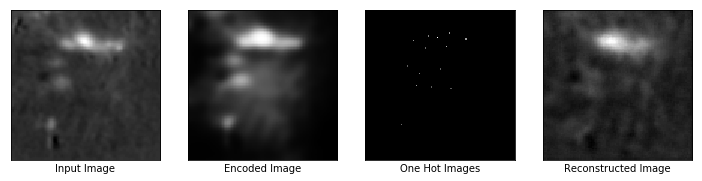

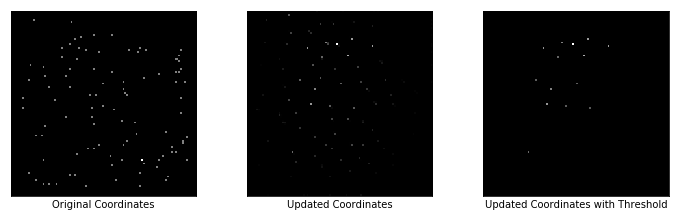

Epochs: 100, Session: 0
Reconstruction Loss: 0.0017320491606369615
Regularizer Loss: 44643.578125, Total Loss: 44643.578125
Encoder Loss: 5.610510349273682
Max Similarity scores: 0.9718562960624695
Updated Coordinates: [[[0.56364423 0.7283917 ]]]
Gradient global min:-0.0014488472370430827, max:0.0017520609544590116
Gradient encoder min:-2.3985185623168945, max:2.947568893432617
Gradient learnable coords min:-1.5854715456953272e-05, max:1.9749913917621598e-05



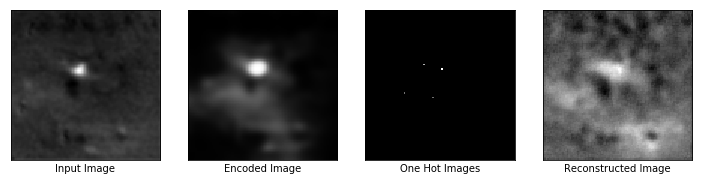

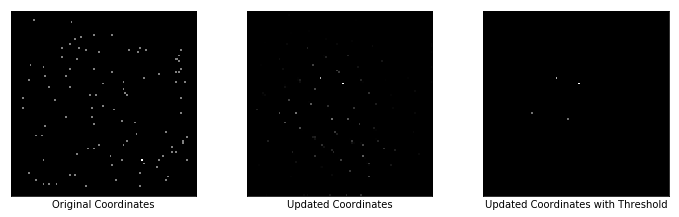

Epochs: 100, Session: 1
Reconstruction Loss: 0.002194649074226618
Regularizer Loss: 44077.84765625, Total Loss: 44077.8515625
Encoder Loss: 1.0605207681655884
Max Similarity scores: 0.7730565071105957
Updated Coordinates: [[[0.5673721  0.71226555]]]
Gradient global min:-0.002498770598322153, max:0.002008056966587901
Gradient encoder min:-0.4218449294567108, max:0.521247923374176
Gradient learnable coords min:-0.00010771189408842474, max:3.7618831356667215e-06



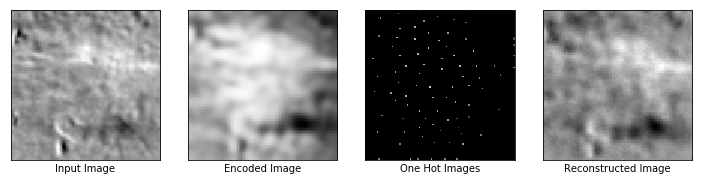

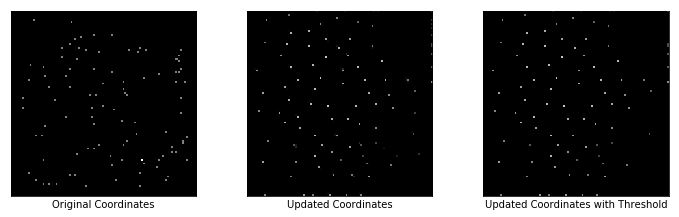

Epochs: 100, Session: 2
Reconstruction Loss: 0.002765265293419361
Regularizer Loss: 49001.9765625, Total Loss: 49001.98046875
Encoder Loss: 9.771947860717773
Max Similarity scores: 0.9534609913825989
Updated Coordinates: [[[0.5553946 0.7385738]]]
Gradient global min:-0.00032994415960274637, max:0.00033691333374008536
Gradient encoder min:-3.653578996658325, max:4.331458568572998
Gradient learnable coords min:-1.959012843144592e-05, max:1.0840454706340097e-05



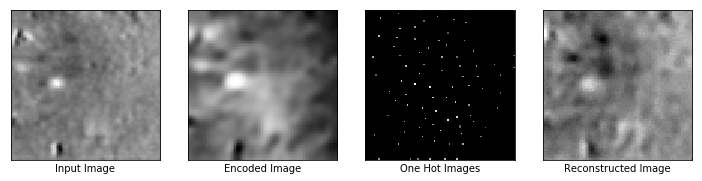

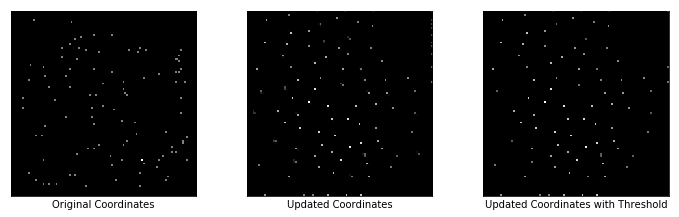

Epochs: 100, Session: 3
Reconstruction Loss: 0.0015632559079676867
Regularizer Loss: 46086.85546875, Total Loss: 46086.85546875
Encoder Loss: 7.38016414642334
Max Similarity scores: 0.978309690952301
Updated Coordinates: [[[0.554498  0.7379247]]]
Gradient global min:-0.00034533636062406003, max:0.0003378804540261626
Gradient encoder min:-3.2019662857055664, max:3.840376377105713
Gradient learnable coords min:-2.392880924162455e-05, max:1.6600215531070717e-05



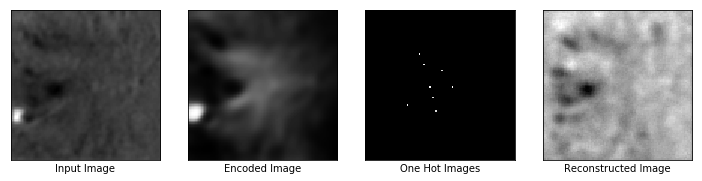

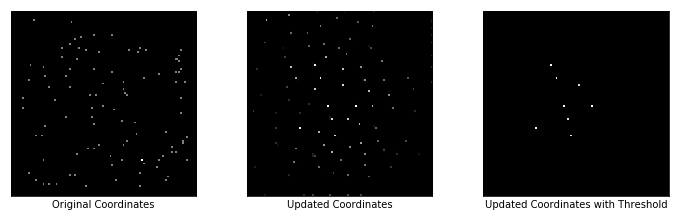

Epochs: 100, Session: 4
Reconstruction Loss: 0.0020254896953701973
Regularizer Loss: 44358.859375, Total Loss: 44358.86328125
Encoder Loss: 4.945122718811035
Max Similarity scores: 0.3989056944847107
Updated Coordinates: [[[0.55410534 0.7370096 ]]]
Gradient global min:-0.0002151571388822049, max:0.0006648652488365769
Gradient encoder min:-2.1857829093933105, max:2.692988157272339
Gradient learnable coords min:-4.7815417929086834e-05, max:8.080832230916712e-06



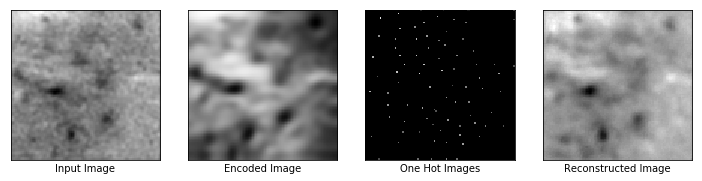

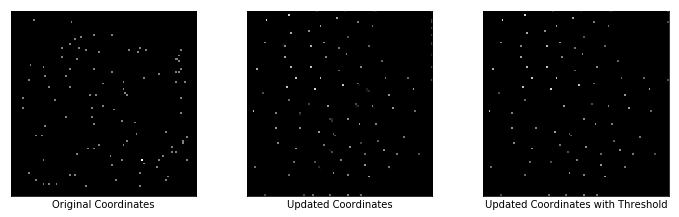

Epochs: 100, Session: 5
Reconstruction Loss: 0.0023769494146108627
Regularizer Loss: 48337.6640625, Total Loss: 48337.66796875
Encoder Loss: 8.76374626159668
Max Similarity scores: 0.9336535334587097
Updated Coordinates: [[[0.5556833  0.73708034]]]
Gradient global min:-0.000204987678444013, max:0.0001779770100256428
Gradient encoder min:-3.6512839794158936, max:4.336568355560303
Gradient learnable coords min:-4.6953482524259016e-05, max:2.026350011874456e-05



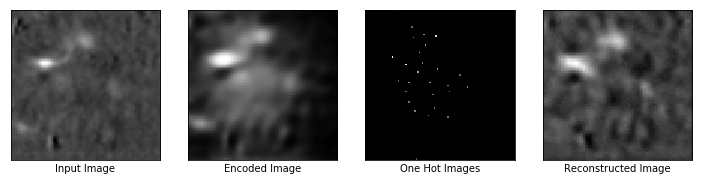

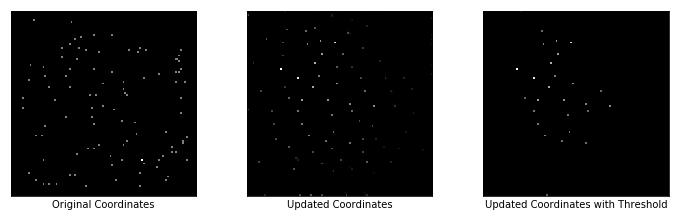

Epochs: 200, Session: 0
Reconstruction Loss: 0.0013588208239525557
Regularizer Loss: 55977.578125, Total Loss: 55977.578125
Encoder Loss: 5.428150177001953
Max Similarity scores: 0.829630970954895
Updated Coordinates: [[[0.55540305 0.71727085]]]
Gradient global min:-0.00040580620407126844, max:0.00025269779143854976
Gradient encoder min:-2.5591351985931396, max:3.2336320877075195
Gradient learnable coords min:-2.4204262444982305e-05, max:2.3234217223944142e-05



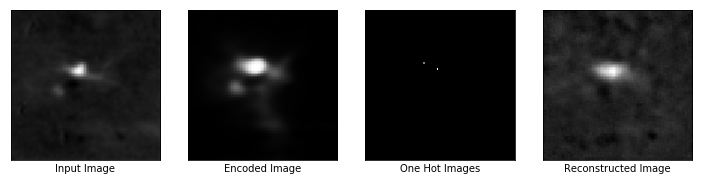

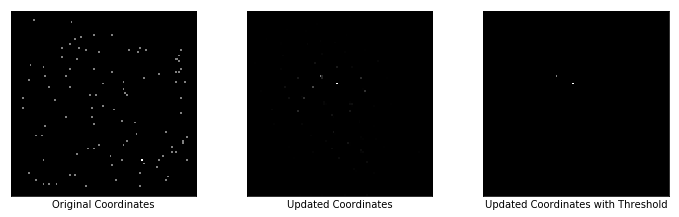

Epochs: 200, Session: 1
Reconstruction Loss: 0.0014920419780537486
Regularizer Loss: 63159.05859375, Total Loss: 63159.05859375
Encoder Loss: 1.0746288299560547
Max Similarity scores: 0.9427597522735596
Updated Coordinates: [[[0.54858947 0.71576446]]]
Gradient global min:-0.0005334073794074357, max:0.0004014295991510153
Gradient encoder min:-0.5809324979782104, max:0.6505963206291199
Gradient learnable coords min:-0.00021521181042771786, max:0.00011496766819618642



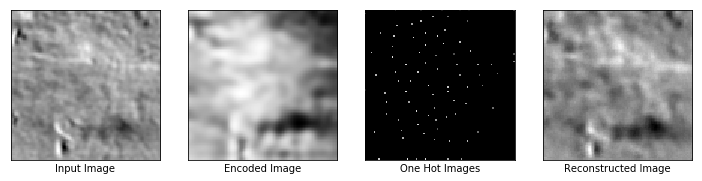

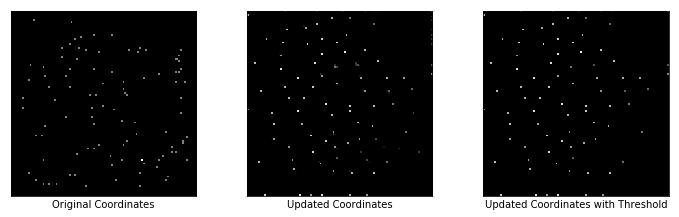

Epochs: 200, Session: 2
Reconstruction Loss: 0.002096142154186964
Regularizer Loss: 56820.59375, Total Loss: 56820.59765625
Encoder Loss: 9.434296607971191
Max Similarity scores: 0.9072549343109131
Updated Coordinates: [[[0.5467386 0.7153022]]]
Gradient global min:-0.00032536094659008086, max:0.00023909061565063894
Gradient encoder min:-4.214730262756348, max:4.933609485626221
Gradient learnable coords min:-1.2081125532859005e-05, max:2.567045157775283e-05



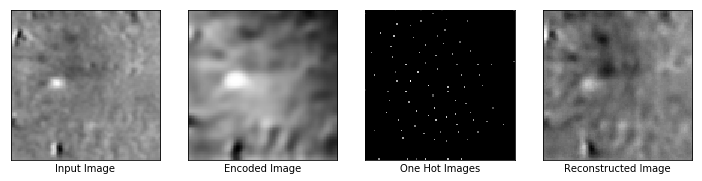

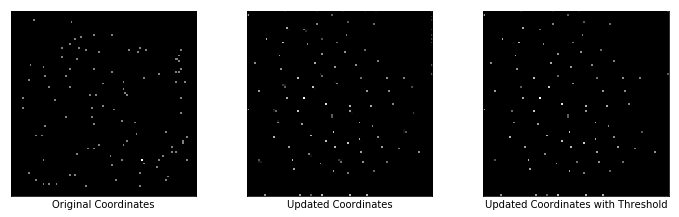

Epochs: 200, Session: 3
Reconstruction Loss: 0.00131822912953794
Regularizer Loss: 55078.2734375, Total Loss: 55078.2734375
Encoder Loss: 7.051431655883789
Max Similarity scores: 0.9944688081741333
Updated Coordinates: [[[0.54364204 0.71600455]]]
Gradient global min:-0.002879922743886709, max:0.0010672014905139804
Gradient encoder min:-3.4548609256744385, max:4.274036407470703
Gradient learnable coords min:-1.3439559552352875e-05, max:1.6725436580600217e-05



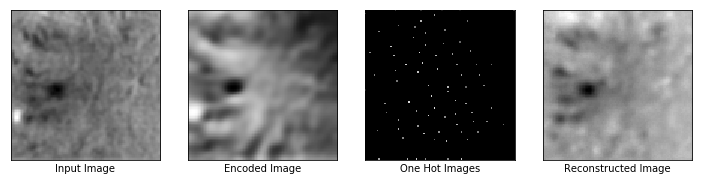

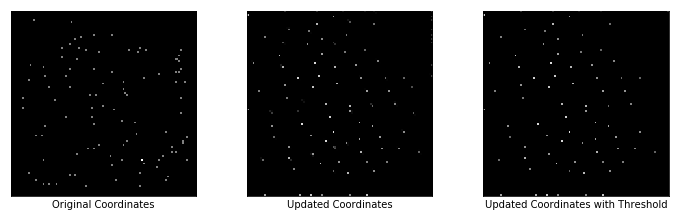

Epochs: 200, Session: 4
Reconstruction Loss: 0.001925313612446189
Regularizer Loss: 56396.71875, Total Loss: 56396.71875
Encoder Loss: 4.832945823669434
Max Similarity scores: 0.7869204878807068
Updated Coordinates: [[[0.53811556 0.7154039 ]]]
Gradient global min:-0.00018175796139985323, max:0.0004858405445702374
Gradient encoder min:-2.2495481967926025, max:2.895430326461792
Gradient learnable coords min:-1.0381819265603554e-05, max:1.544569749967195e-05



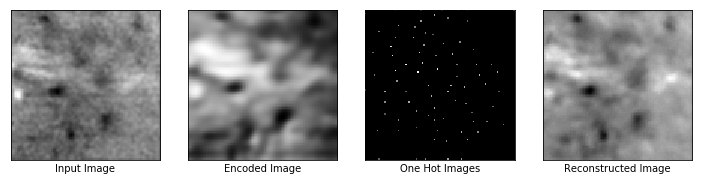

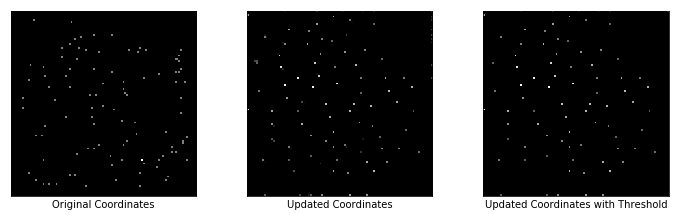

Epochs: 200, Session: 5
Reconstruction Loss: 0.002097771503031254
Regularizer Loss: 56611.2578125, Total Loss: 56611.26171875
Encoder Loss: 8.471644401550293
Max Similarity scores: 0.9162577390670776
Updated Coordinates: [[[0.5285456  0.72916865]]]
Gradient global min:-0.0005047988961450756, max:0.0006085695349611342
Gradient encoder min:-4.025383472442627, max:4.863007545471191
Gradient learnable coords min:-1.4378505511558615e-05, max:1.8408838514005765e-05



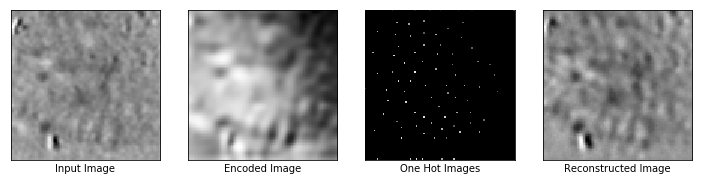

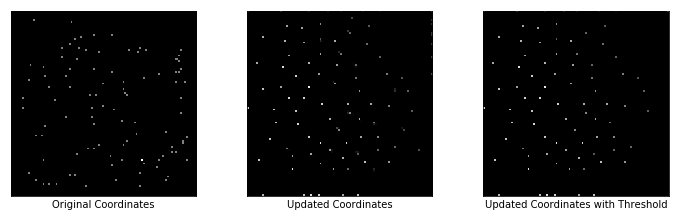

Epochs: 300, Session: 0
Reconstruction Loss: 0.0011719544418156147
Regularizer Loss: 69972.9375, Total Loss: 69972.9375
Encoder Loss: 5.467308521270752
Max Similarity scores: 0.8944284915924072
Updated Coordinates: [[[0.5340992 0.7169661]]]
Gradient global min:-0.000570050033275038, max:0.0005048606544733047
Gradient encoder min:-2.8310036659240723, max:4.0532546043396
Gradient learnable coords min:-3.955403735744767e-05, max:7.253122748807073e-05



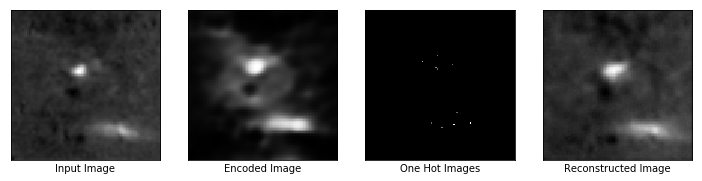

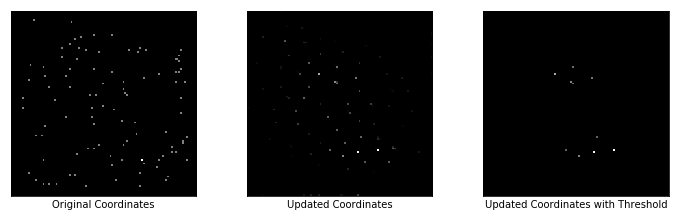

Epochs: 300, Session: 1
Reconstruction Loss: 0.001229272224009037
Regularizer Loss: 76605.421875, Total Loss: 76605.421875
Encoder Loss: 1.095835566520691
Max Similarity scores: 0.9175388813018799
Updated Coordinates: [[[0.5277443  0.71495193]]]
Gradient global min:-0.0005723064532503486, max:0.00038960532401688397
Gradient encoder min:-0.5896603465080261, max:0.767522931098938
Gradient learnable coords min:-0.00011529108451213688, max:5.782593143521808e-05



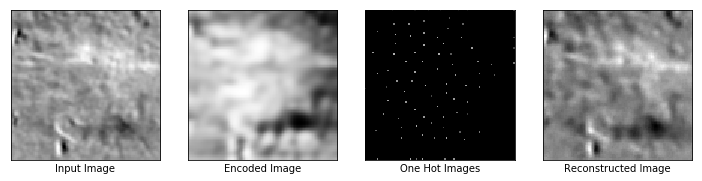

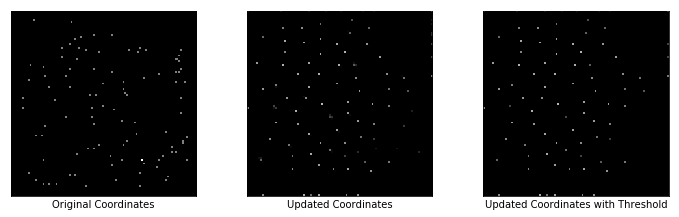

Epochs: 300, Session: 2
Reconstruction Loss: 0.0016607166035100818
Regularizer Loss: 72765.953125, Total Loss: 72765.953125
Encoder Loss: 9.475931167602539
Max Similarity scores: 0.9344576001167297
Updated Coordinates: [[[0.5238848 0.7156574]]]
Gradient global min:-0.0006381904240697622, max:0.0005235675489529967
Gradient encoder min:-4.717766761779785, max:6.470420837402344
Gradient learnable coords min:-6.830762686149683e-06, max:6.966090040805284e-06



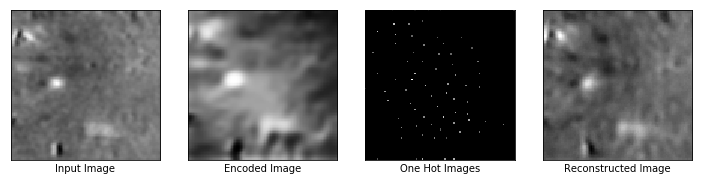

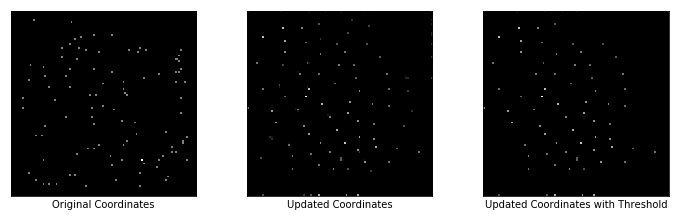

Epochs: 300, Session: 3
Reconstruction Loss: 0.0011366349644958973
Regularizer Loss: 69276.75, Total Loss: 69276.75
Encoder Loss: 7.375786304473877
Max Similarity scores: 0.9850680232048035
Updated Coordinates: [[[0.52402097 0.715958  ]]]
Gradient global min:-0.007206369657069445, max:0.00493884552270174
Gradient encoder min:-3.948223114013672, max:5.587032318115234
Gradient learnable coords min:-2.4856017262209207e-05, max:1.4543879842676688e-05



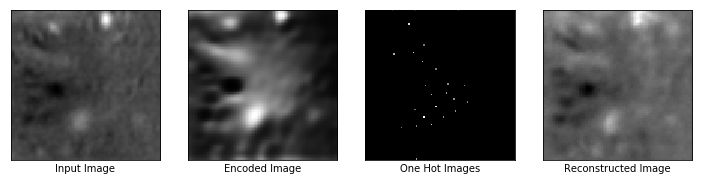

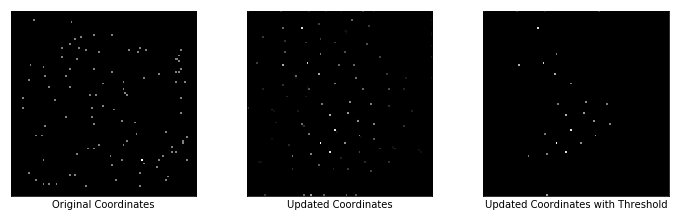

Epochs: 300, Session: 4
Reconstruction Loss: 0.0016496044117957354
Regularizer Loss: 69769.7265625, Total Loss: 69769.7265625
Encoder Loss: 4.953593730926514
Max Similarity scores: 0.6821032166481018
Updated Coordinates: [[[0.5241769 0.7151268]]]
Gradient global min:-0.0031401815358549356, max:0.002057053614407778
Gradient encoder min:-2.5503101348876953, max:3.7124173641204834
Gradient learnable coords min:-1.900181632663589e-05, max:9.738106200529728e-06



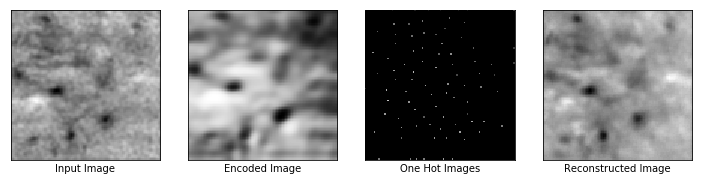

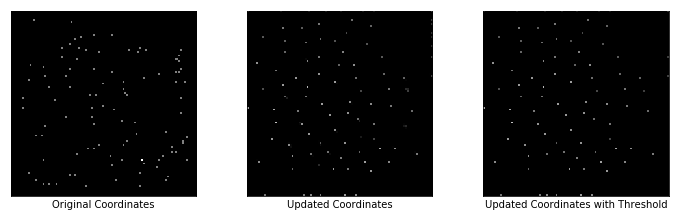

Epochs: 300, Session: 5
Reconstruction Loss: 0.0019459876930341125
Regularizer Loss: 72563.375, Total Loss: 72563.375
Encoder Loss: 8.60007095336914
Max Similarity scores: 0.9823279976844788
Updated Coordinates: [[[0.5238226 0.7152244]]]
Gradient global min:-0.0004198194365017116, max:0.00016017533198464662
Gradient encoder min:-4.638838768005371, max:6.44805383682251
Gradient learnable coords min:-7.5576972449198365e-06, max:1.213550513057271e-05



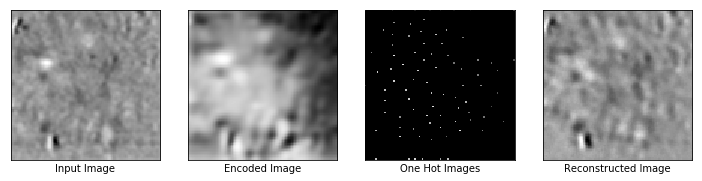

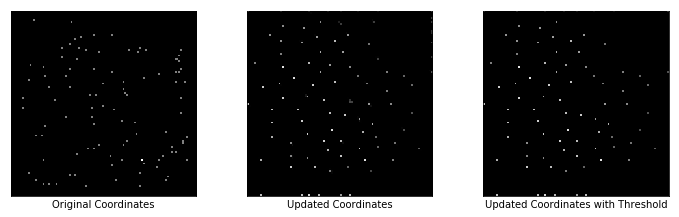

Epochs: 400, Session: 0
Reconstruction Loss: 0.0010650871554389596
Regularizer Loss: 97025.265625, Total Loss: 97025.265625
Encoder Loss: 5.326970100402832
Max Similarity scores: 0.890974760055542
Updated Coordinates: [[[0.50773394 0.7060178 ]]]
Gradient global min:-0.0033616882283240557, max:0.004360993392765522
Gradient encoder min:-2.640990972518921, max:3.935713291168213
Gradient learnable coords min:-4.530841124505969e-06, max:1.4798089978285134e-05



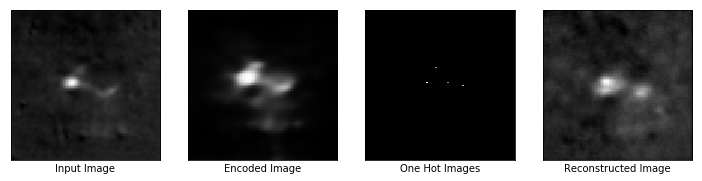

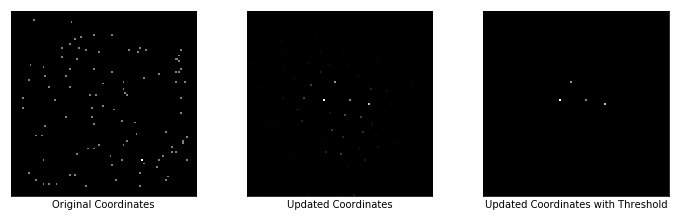

Epochs: 400, Session: 1
Reconstruction Loss: 0.0009729606681503356
Regularizer Loss: 102406.7265625, Total Loss: 102406.7265625
Encoder Loss: 1.1243946552276611
Max Similarity scores: 0.8416162133216858
Updated Coordinates: [[[0.5159215 0.6890156]]]
Gradient global min:-8.236970461439341e-05, max:8.95740813575685e-05
Gradient encoder min:-0.5452961325645447, max:0.7190859317779541
Gradient learnable coords min:-1.1075252587033901e-05, max:1.57412559929071e-05



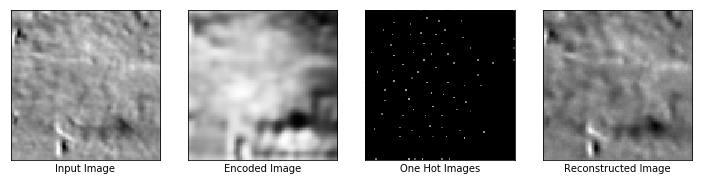

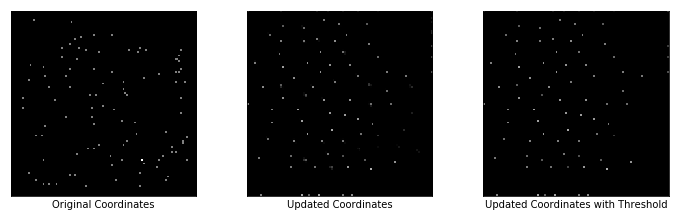

Epochs: 400, Session: 2
Reconstruction Loss: 0.0014451401075348258
Regularizer Loss: 102177.34375, Total Loss: 102177.34375
Encoder Loss: 9.171992301940918
Max Similarity scores: 0.9368195533752441
Updated Coordinates: [[[0.51456237 0.70289034]]]
Gradient global min:-0.0016282442957162857, max:0.0014156000688672066
Gradient encoder min:-4.263976097106934, max:6.365035533905029
Gradient learnable coords min:-9.275363481719978e-06, max:1.4321589333121665e-05



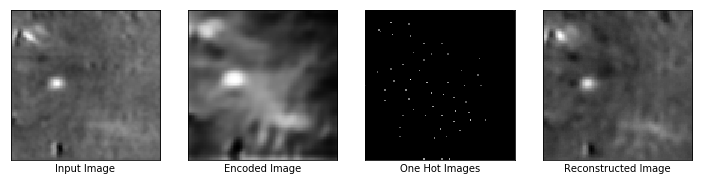

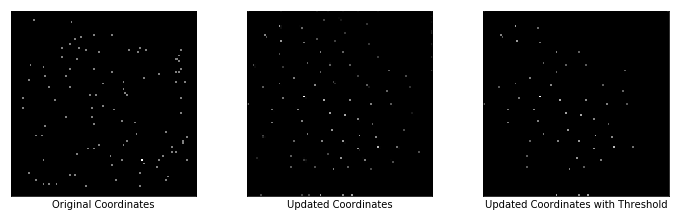

Epochs: 400, Session: 3
Reconstruction Loss: 0.0011071281041949987
Regularizer Loss: 96755.4921875, Total Loss: 96755.4921875
Encoder Loss: 7.003530502319336
Max Similarity scores: 0.9830363988876343
Updated Coordinates: [[[0.51599765 0.7056655 ]]]
Gradient global min:-0.007434874773025513, max:0.005525433924049139
Gradient encoder min:-3.74590802192688, max:5.455789089202881
Gradient learnable coords min:-1.043931843014434e-05, max:1.9299221094115637e-05



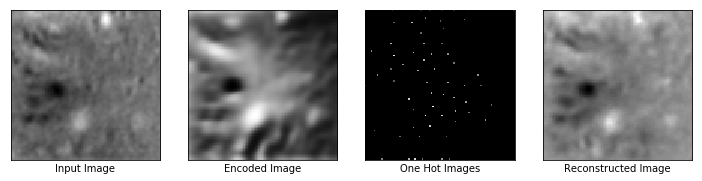

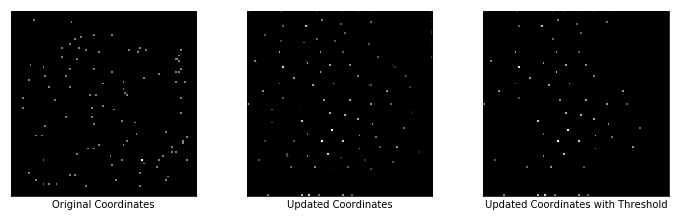

Epochs: 400, Session: 4
Reconstruction Loss: 0.0013742271112278104
Regularizer Loss: 96213.328125, Total Loss: 96213.328125
Encoder Loss: 4.715798854827881
Max Similarity scores: 0.8599539399147034
Updated Coordinates: [[[0.51432693 0.70651555]]]
Gradient global min:-0.00035398639738559723, max:0.00030622302438132465
Gradient encoder min:-2.363633155822754, max:3.466707706451416
Gradient learnable coords min:-1.006639013212407e-05, max:1.4051508514967281e-05



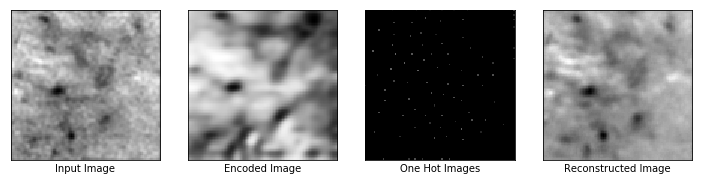

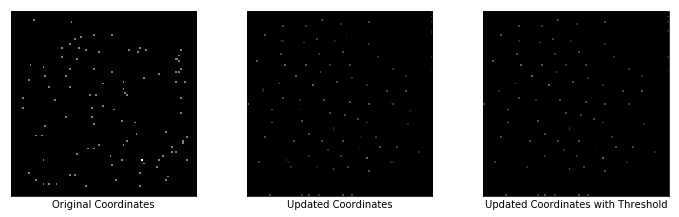

Epochs: 400, Session: 5
Reconstruction Loss: 0.0019155475310981274
Regularizer Loss: 101544.53125, Total Loss: 101544.53125
Encoder Loss: 8.274126052856445
Max Similarity scores: 0.9558282494544983
Updated Coordinates: [[[0.5142666  0.70655185]]]
Gradient global min:-0.0016776612028479576, max:0.002400094410404563
Gradient encoder min:-4.380730152130127, max:6.472283840179443
Gradient learnable coords min:-2.2270924091571942e-05, max:2.8415548513294198e-05



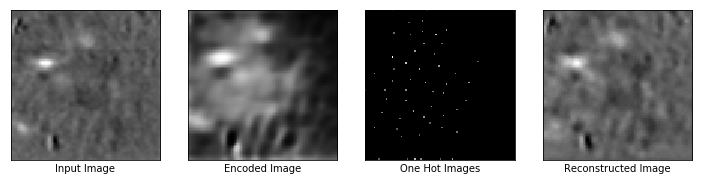

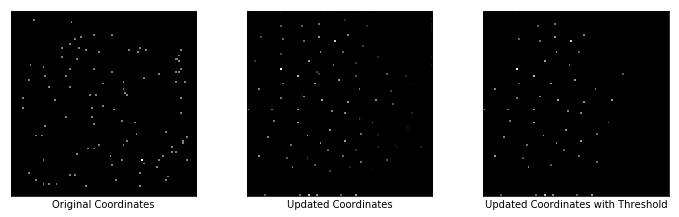

Epochs: 500, Session: 0
Reconstruction Loss: 0.0009957210859283805
Regularizer Loss: 128795.28125, Total Loss: 128795.28125
Encoder Loss: 5.295129299163818
Max Similarity scores: 0.8927992582321167
Updated Coordinates: [[[0.525033   0.70688343]]]
Gradient global min:-0.00040815246757119894, max:0.00039207839290611446
Gradient encoder min:-2.8801980018615723, max:2.479583501815796
Gradient learnable coords min:-1.6933237930061296e-05, max:4.331448053562781e-06



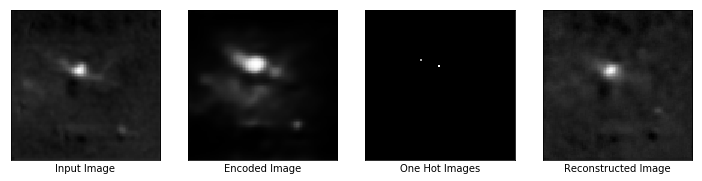

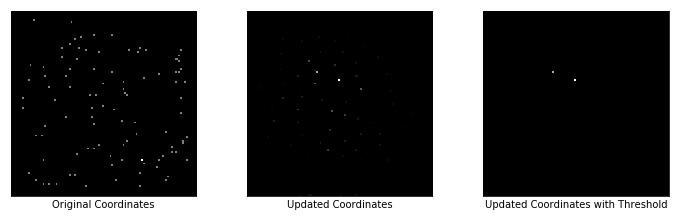

Epochs: 500, Session: 1
Reconstruction Loss: 0.000917833240237087
Regularizer Loss: 140319.859375, Total Loss: 140319.859375
Encoder Loss: 1.2198035717010498
Max Similarity scores: 0.7910301685333252
Updated Coordinates: [[[0.52331674 0.70729405]]]
Gradient global min:-0.000899491598829627, max:0.0009197082836180925
Gradient encoder min:-0.5209574103355408, max:0.554938554763794
Gradient learnable coords min:-4.0169612475438043e-05, max:4.403675120556727e-05



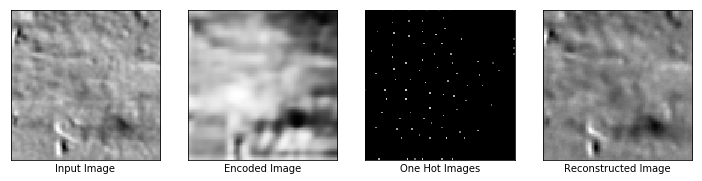

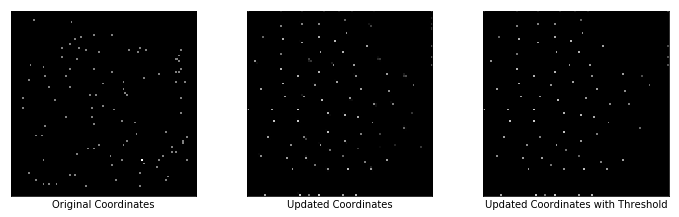

Epochs: 500, Session: 2
Reconstruction Loss: 0.001287072547711432
Regularizer Loss: 131631.0, Total Loss: 131631.0
Encoder Loss: 9.189682960510254
Max Similarity scores: 0.9272816181182861
Updated Coordinates: [[[0.52696556 0.70498866]]]
Gradient global min:-0.0017843416426330805, max:0.0014552095672115684
Gradient encoder min:-4.851723670959473, max:4.1621904373168945
Gradient learnable coords min:-1.2942791727255099e-05, max:3.0035130293981638e-06



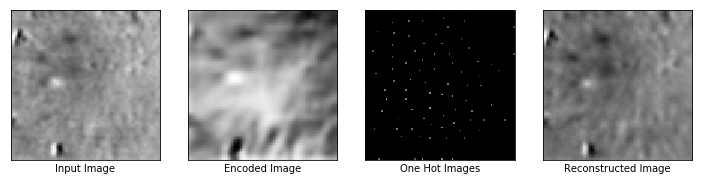

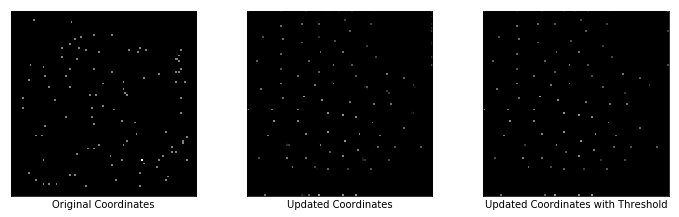

Epochs: 500, Session: 3
Reconstruction Loss: 0.0008939806139096618
Regularizer Loss: 126393.6953125, Total Loss: 126393.6953125
Encoder Loss: 6.903138637542725
Max Similarity scores: 0.9257068037986755
Updated Coordinates: [[[0.5232663 0.7070305]]]
Gradient global min:-0.0013262644642964005, max:0.0011499702231958508
Gradient encoder min:-4.112061977386475, max:3.4354615211486816
Gradient learnable coords min:-1.15248876682017e-05, max:9.025437611853704e-05



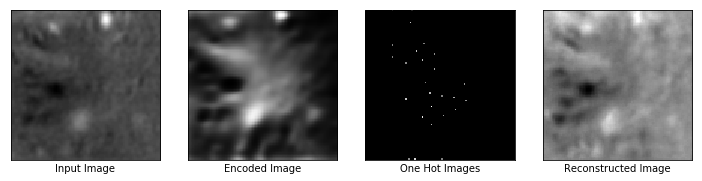

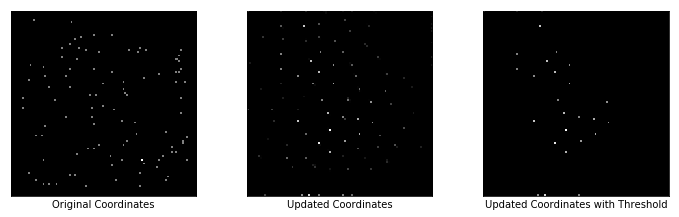

Epochs: 500, Session: 4
Reconstruction Loss: 0.0013262218562886119
Regularizer Loss: 127998.78125, Total Loss: 127998.78125
Encoder Loss: 4.683610439300537
Max Similarity scores: 0.6496312022209167
Updated Coordinates: [[[0.52442294 0.70617104]]]
Gradient global min:-0.0014519215328618884, max:0.001366922166198492
Gradient encoder min:-2.543081283569336, max:2.21647572517395
Gradient learnable coords min:-1.8127257135347463e-05, max:3.6829980672337115e-05



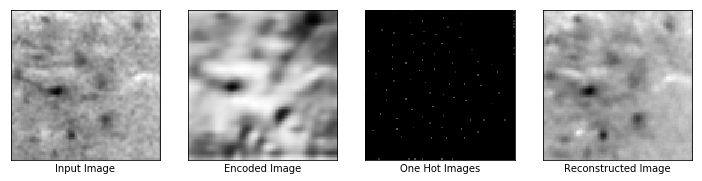

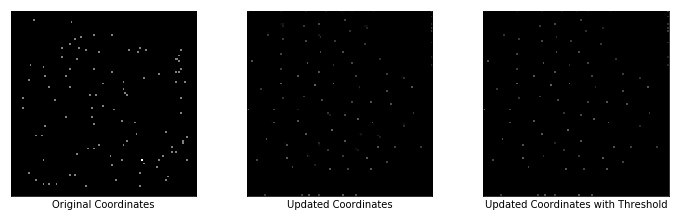

Epochs: 500, Session: 5
Reconstruction Loss: 0.001822461374104023
Regularizer Loss: 130962.96875, Total Loss: 130962.96875
Encoder Loss: 8.219219207763672
Max Similarity scores: 0.922892153263092
Updated Coordinates: [[[0.52419734 0.7063278 ]]]
Gradient global min:-0.00016376955318264663, max:0.0003351609339006245
Gradient encoder min:-4.758490562438965, max:4.029612064361572
Gradient learnable coords min:-1.6067162505351007e-05, max:5.2315670473035425e-05



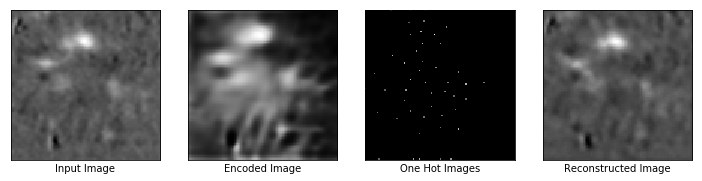

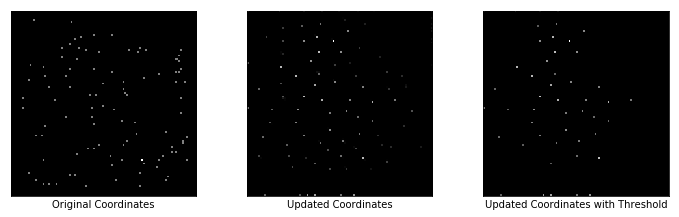

Epochs: 600, Session: 0
Reconstruction Loss: 0.0009236205951310694
Regularizer Loss: 186601.8125, Total Loss: 186601.8125
Encoder Loss: 4.902740478515625
Max Similarity scores: 0.900316059589386
Updated Coordinates: [[[0.51653194 0.70428264]]]
Gradient global min:-0.0004437239549588412, max:0.0004792744875885546
Gradient encoder min:-2.308154821395874, max:1.7975130081176758
Gradient learnable coords min:-7.388102676486596e-05, max:4.030962008982897e-05



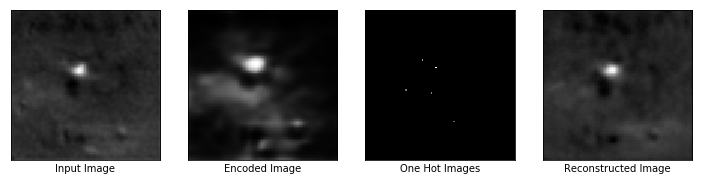

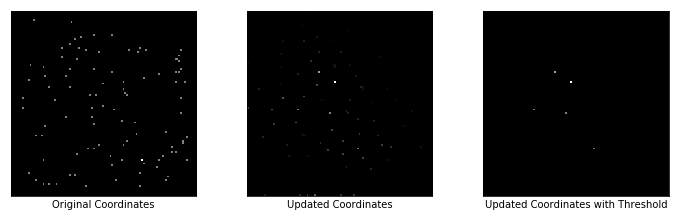

Epochs: 600, Session: 1
Reconstruction Loss: 0.000771690218243748
Regularizer Loss: 207496.953125, Total Loss: 207496.953125
Encoder Loss: 1.1116533279418945
Max Similarity scores: 0.7814211249351501
Updated Coordinates: [[[0.51445657 0.7073794 ]]]
Gradient global min:-0.0009489285876043141, max:0.0006847029435448349
Gradient encoder min:-0.45070311427116394, max:0.38867154717445374
Gradient learnable coords min:-3.584393562050536e-05, max:8.944277942646295e-05



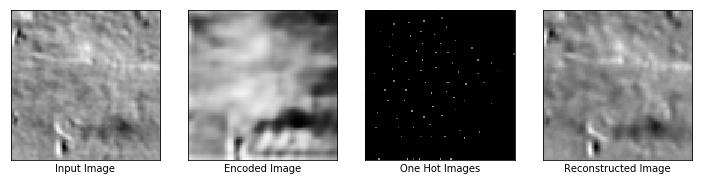

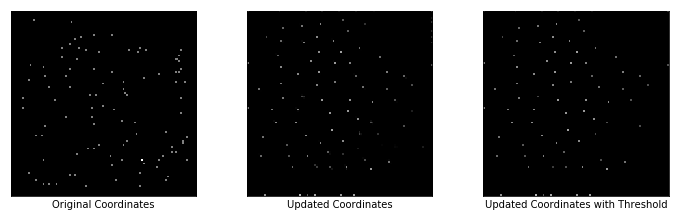

Epochs: 600, Session: 2
Reconstruction Loss: 0.00119340093806386
Regularizer Loss: 183712.765625, Total Loss: 183712.765625
Encoder Loss: 8.351705551147461
Max Similarity scores: 0.939132809638977
Updated Coordinates: [[[0.51498216 0.70715356]]]
Gradient global min:-0.0005849081207998097, max:0.00029980926774442196
Gradient encoder min:-3.9024577140808105, max:2.9843616485595703
Gradient learnable coords min:-9.708734069135971e-06, max:2.4641785785206594e-05



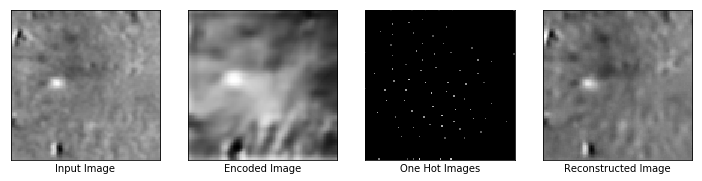

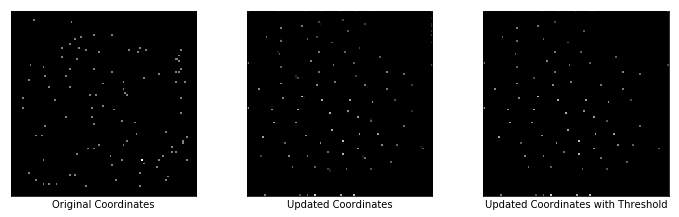

Epochs: 600, Session: 3
Reconstruction Loss: 0.0007644869619980454
Regularizer Loss: 179290.34375, Total Loss: 179290.34375
Encoder Loss: 6.383671760559082
Max Similarity scores: 0.9490934014320374
Updated Coordinates: [[[0.5153311  0.70655584]]]
Gradient global min:-0.0004072976007591933, max:0.00041357395821250975
Gradient encoder min:-3.10469913482666, max:2.3523056507110596
Gradient learnable coords min:-3.4917923130706185e-06, max:5.206818514125189e-06



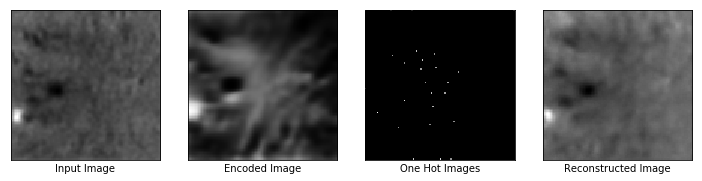

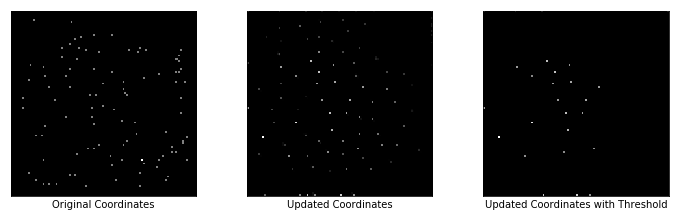

Epochs: 600, Session: 4
Reconstruction Loss: 0.0010318710701540112
Regularizer Loss: 185822.265625, Total Loss: 185822.265625
Encoder Loss: 4.223301887512207
Max Similarity scores: 0.5784925818443298
Updated Coordinates: [[[0.51475084 0.70588374]]]
Gradient global min:-0.005492147523909807, max:0.006680984981358051
Gradient encoder min:-1.994904637336731, max:1.538742184638977
Gradient learnable coords min:-5.758070255978964e-05, max:7.658937101950869e-05



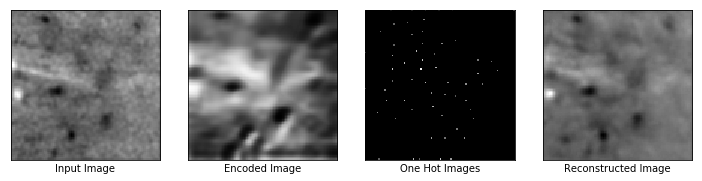

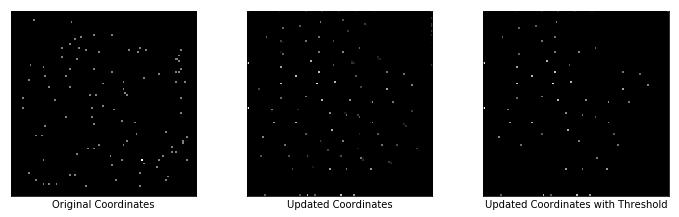

Epochs: 600, Session: 5
Reconstruction Loss: 0.0016950733261182904
Regularizer Loss: 183235.6875, Total Loss: 183235.6875
Encoder Loss: 7.513879299163818
Max Similarity scores: 0.8850505948066711
Updated Coordinates: [[[0.5152516 0.7057267]]]
Gradient global min:-0.004286990500986576, max:0.0027750059962272644
Gradient encoder min:-3.805569648742676, max:2.886183977127075
Gradient learnable coords min:-1.7892714822664857e-05, max:6.042780114512425e-06



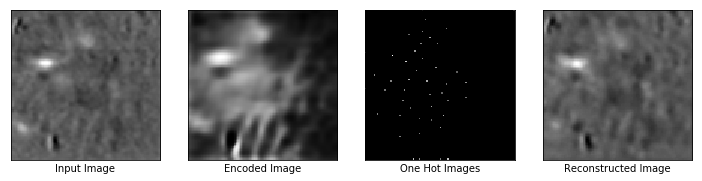

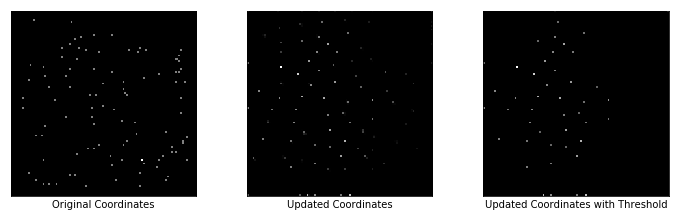

Epochs: 700, Session: 0
Reconstruction Loss: 0.0009166050003841519
Regularizer Loss: 237185.765625, Total Loss: 237185.765625
Encoder Loss: 4.606240272521973
Max Similarity scores: 0.8117367029190063
Updated Coordinates: [[[0.5245926  0.70630664]]]
Gradient global min:-0.0005350371357053518, max:0.000650288478937
Gradient encoder min:-2.491281509399414, max:1.7894536256790161
Gradient learnable coords min:-2.0606048565241508e-05, max:2.748621227510739e-05



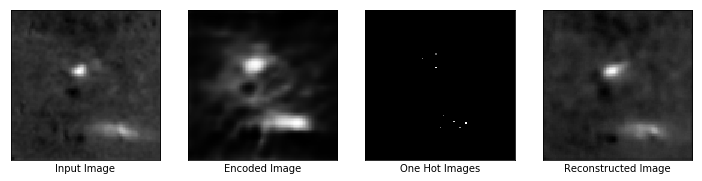

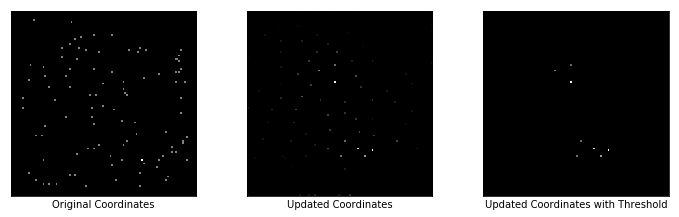

Epochs: 700, Session: 1
Reconstruction Loss: 0.0007752952515147626
Regularizer Loss: 260371.171875, Total Loss: 260371.171875
Encoder Loss: 1.079993724822998
Max Similarity scores: 0.8506060242652893
Updated Coordinates: [[[0.523164  0.7069416]]]
Gradient global min:-0.00023999816039577127, max:0.00013004933134652674
Gradient encoder min:-0.4282035529613495, max:0.541369616985321
Gradient learnable coords min:-2.9439301215461455e-05, max:4.223575160722248e-05



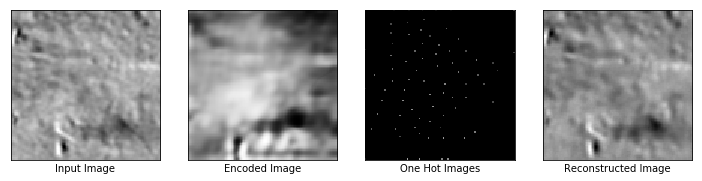

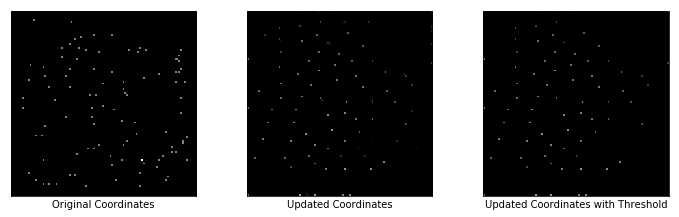

Epochs: 700, Session: 2
Reconstruction Loss: 0.0011456308420747519
Regularizer Loss: 231659.75, Total Loss: 231659.75
Encoder Loss: 7.8816046714782715
Max Similarity scores: 0.9393661618232727
Updated Coordinates: [[[0.5250234 0.706951 ]]]
Gradient global min:-0.006334370467811823, max:0.00924739520996809
Gradient encoder min:-4.3712568283081055, max:2.912890911102295
Gradient learnable coords min:-2.1965050109429285e-05, max:1.2029973731841892e-05



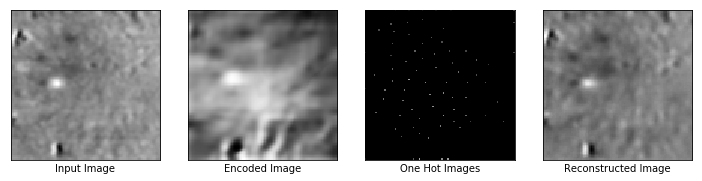

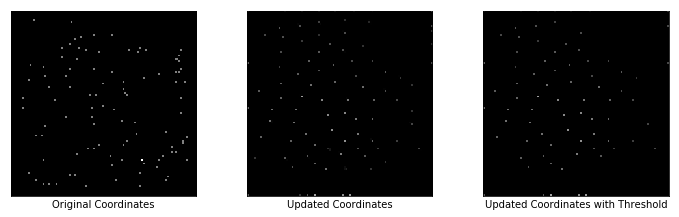

Epochs: 700, Session: 3
Reconstruction Loss: 0.0007934949244372547
Regularizer Loss: 227428.59375, Total Loss: 227428.59375
Encoder Loss: 5.986572742462158
Max Similarity scores: 0.9065122008323669
Updated Coordinates: [[[0.5242373 0.7067705]]]
Gradient global min:-0.0002870936878025532, max:0.0004822017508558929
Gradient encoder min:-3.505899667739868, max:2.410555124282837
Gradient learnable coords min:-6.41855331195984e-06, max:4.357978104962967e-05



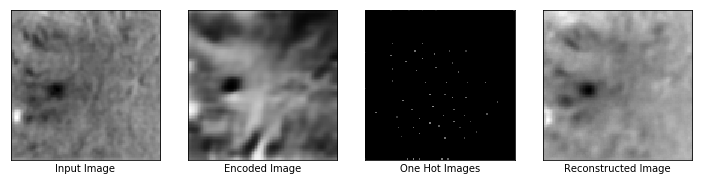

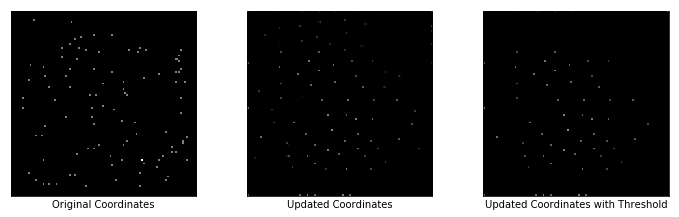

Epochs: 700, Session: 4
Reconstruction Loss: 0.0010006106458604336
Regularizer Loss: 236618.921875, Total Loss: 236618.921875
Encoder Loss: 4.006225109100342
Max Similarity scores: 0.6937381029129028
Updated Coordinates: [[[0.52363056 0.70322865]]]
Gradient global min:-0.0006160341436043382, max:0.0008811889565549791
Gradient encoder min:-2.088527202606201, max:1.594977855682373
Gradient learnable coords min:-8.889362106856424e-06, max:1.4679246305604465e-05



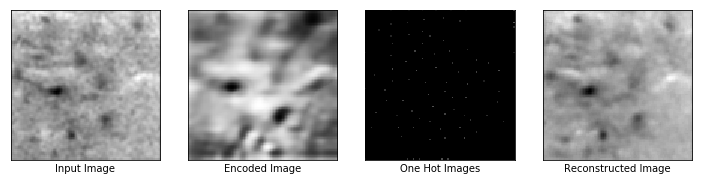

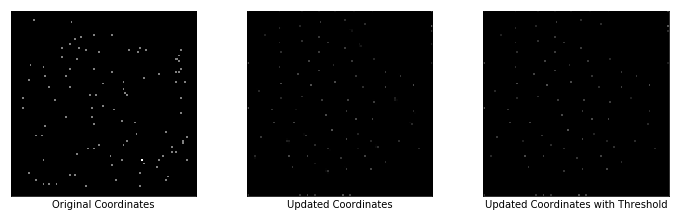

Epochs: 700, Session: 5
Reconstruction Loss: 0.0016619110247120261
Regularizer Loss: 231077.171875, Total Loss: 231077.171875
Encoder Loss: 7.141292572021484
Max Similarity scores: 0.9037835597991943
Updated Coordinates: [[[0.53446996 0.69886327]]]
Gradient global min:-0.0004197282833047211, max:0.00044537513167597353
Gradient encoder min:-4.281249523162842, max:2.8319485187530518
Gradient learnable coords min:-6.34027092019096e-05, max:4.10781467508059e-05



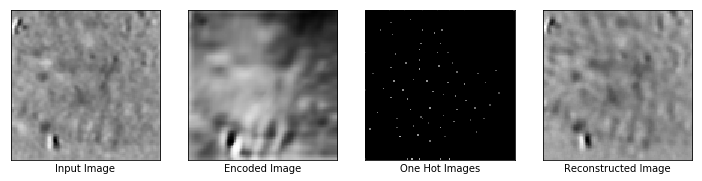

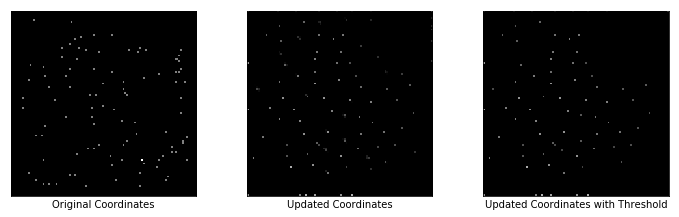

Epochs: 800, Session: 0
Reconstruction Loss: 0.0009724956471472979
Regularizer Loss: 297726.71875, Total Loss: 297726.71875
Encoder Loss: 4.59916877746582
Max Similarity scores: 0.8554413914680481
Updated Coordinates: [[[0.5236558 0.7007994]]]
Gradient global min:-0.0007999785011634231, max:0.0005846119020134211
Gradient encoder min:-1.6600937843322754, max:1.7495863437652588
Gradient learnable coords min:-5.1657621952472255e-05, max:6.530560494866222e-05



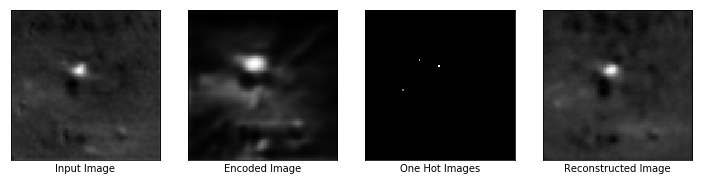

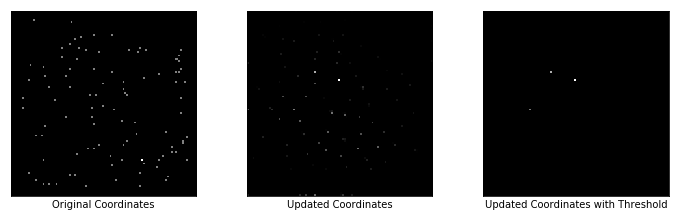

Epochs: 800, Session: 1
Reconstruction Loss: 0.0007221263949759305
Regularizer Loss: 320894.15625, Total Loss: 320894.15625
Encoder Loss: 1.0829490423202515
Max Similarity scores: 0.6393400430679321
Updated Coordinates: [[[0.5202819 0.6974368]]]
Gradient global min:-0.0007016401505097747, max:0.0005562071455642581
Gradient encoder min:-0.3661969006061554, max:0.5434886813163757
Gradient learnable coords min:-1.6003685232135467e-05, max:1.1510367585287895e-05



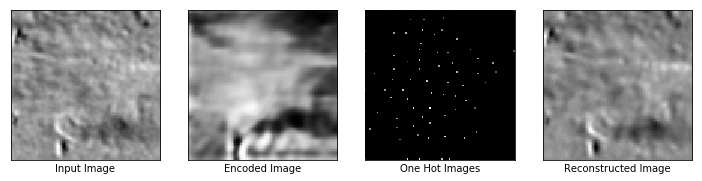

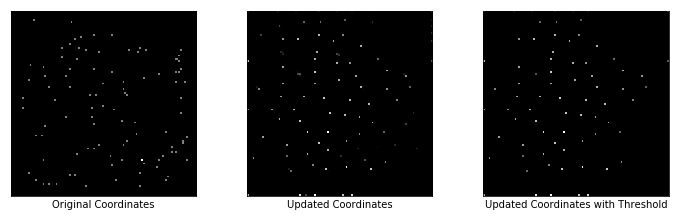

Epochs: 800, Session: 2
Reconstruction Loss: 0.0010861520422622561
Regularizer Loss: 293744.90625, Total Loss: 293744.90625
Encoder Loss: 7.979877471923828
Max Similarity scores: 0.9292986392974854
Updated Coordinates: [[[0.5338553  0.70709443]]]
Gradient global min:-0.0014044427080079913, max:0.0012650589924305677
Gradient encoder min:-3.331907272338867, max:3.0612967014312744
Gradient learnable coords min:-7.761615052004345e-06, max:1.1647648534562904e-05



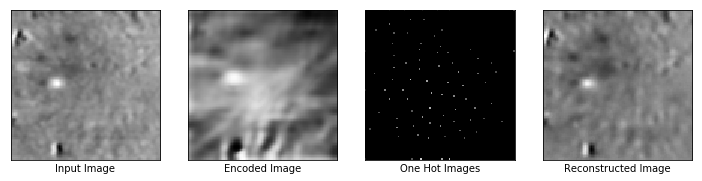

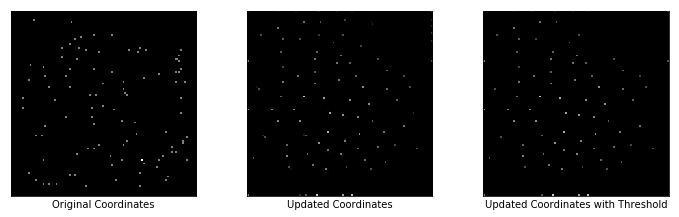

Epochs: 800, Session: 3
Reconstruction Loss: 0.0007511909352615476
Regularizer Loss: 288103.625, Total Loss: 288103.625
Encoder Loss: 5.907590389251709
Max Similarity scores: 0.9115405082702637
Updated Coordinates: [[[0.52740484 0.703973  ]]]
Gradient global min:-0.0008962051360867918, max:0.0003590596606954932
Gradient encoder min:-2.3005716800689697, max:2.296961784362793
Gradient learnable coords min:-7.474487574654631e-06, max:2.4831926566548645e-05



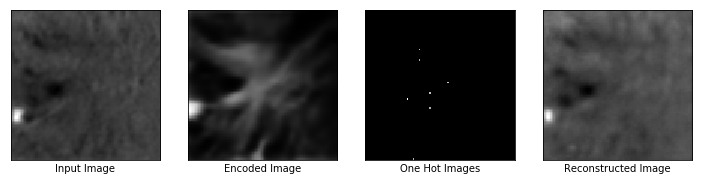

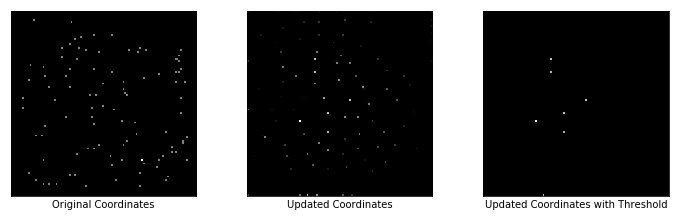

Epochs: 800, Session: 4
Reconstruction Loss: 0.0009121690527535975
Regularizer Loss: 297389.75, Total Loss: 297389.75
Encoder Loss: 3.8347628116607666
Max Similarity scores: 0.46748003363609314
Updated Coordinates: [[[0.5242878 0.6965851]]]
Gradient global min:-0.00010193956404691562, max:0.0001570784079376608
Gradient encoder min:-1.2848836183547974, max:1.493371844291687
Gradient learnable coords min:-1.315824283665279e-05, max:2.9550174076575786e-05



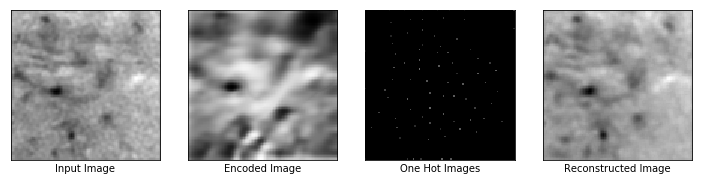

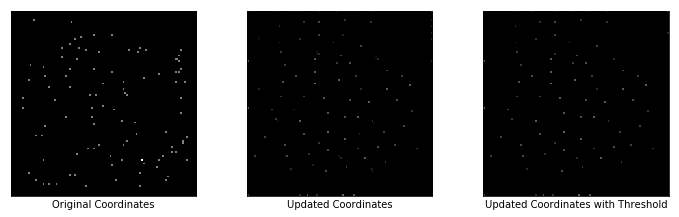

Epochs: 800, Session: 5
Reconstruction Loss: 0.0015984438359737396
Regularizer Loss: 293985.9375, Total Loss: 293985.9375
Encoder Loss: 7.058682441711426
Max Similarity scores: 0.8640559315681458
Updated Coordinates: [[[0.524458  0.6963703]]]
Gradient global min:-0.005340639501810074, max:0.004557674750685692
Gradient encoder min:-3.0471174716949463, max:2.8417980670928955
Gradient learnable coords min:-1.507907290942967e-05, max:3.413400918361731e-06



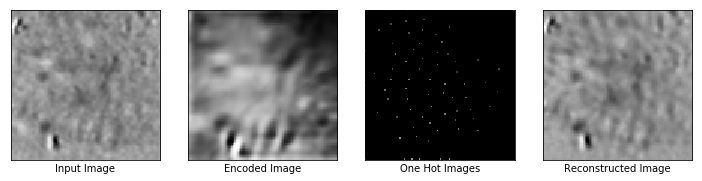

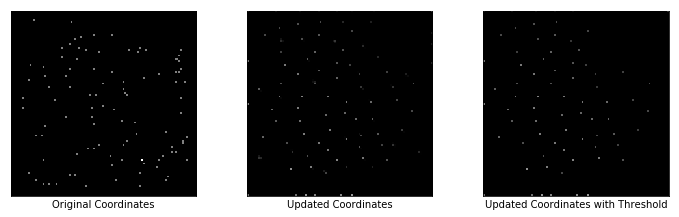

Epochs: 900, Session: 0
Reconstruction Loss: 0.000873576442245394
Regularizer Loss: 369192.6875, Total Loss: 369192.6875
Encoder Loss: 4.316066741943359
Max Similarity scores: 0.8719009757041931
Updated Coordinates: [[[0.53244567 0.6971511 ]]]
Gradient global min:-5.809287540614605e-05, max:9.204377420246601e-05
Gradient encoder min:-1.3826067447662354, max:1.7250421047210693
Gradient learnable coords min:-4.831104524782859e-05, max:2.3597476683789864e-05



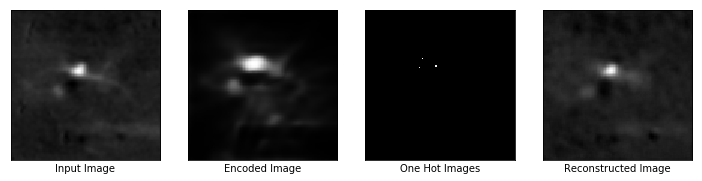

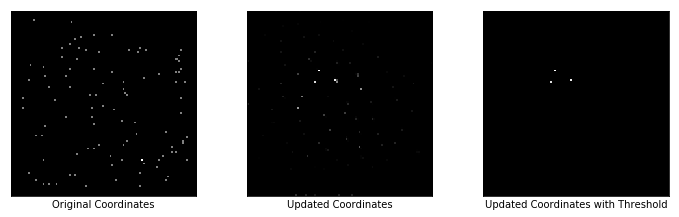

Epochs: 900, Session: 1
Reconstruction Loss: 0.0006519924500025809
Regularizer Loss: 391163.28125, Total Loss: 391163.28125
Encoder Loss: 1.0235060453414917
Max Similarity scores: 0.8160790801048279
Updated Coordinates: [[[0.536942  0.6934632]]]
Gradient global min:-0.000341380073223263, max:0.000383604085072875
Gradient encoder min:-0.3320769667625427, max:0.4214266538619995
Gradient learnable coords min:-1.1010110938514117e-05, max:2.9125658329576254e-05



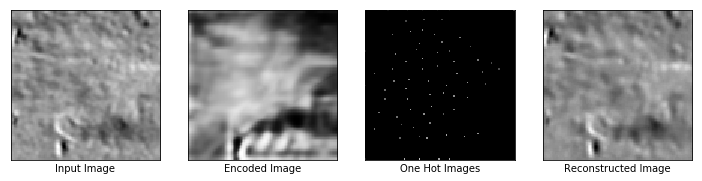

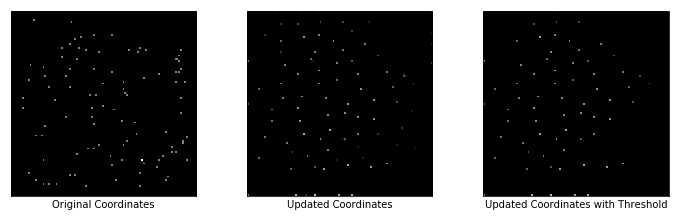

Epochs: 900, Session: 2
Reconstruction Loss: 0.0010546287521719933
Regularizer Loss: 367789.78125, Total Loss: 367789.78125
Encoder Loss: 7.891053676605225
Max Similarity scores: 0.9422814249992371
Updated Coordinates: [[[0.5218551  0.69856447]]]
Gradient global min:-0.0011108678299933672, max:0.0012530784588307142
Gradient encoder min:-2.751509666442871, max:3.503167152404785
Gradient learnable coords min:-2.9755819923593663e-05, max:4.284561873646453e-05



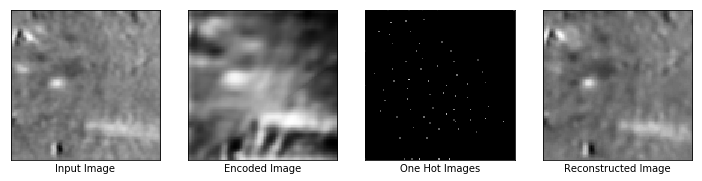

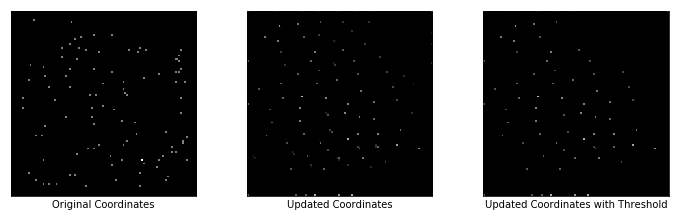

Epochs: 900, Session: 3
Reconstruction Loss: 0.00073770631570369
Regularizer Loss: 360449.0625, Total Loss: 360449.0625
Encoder Loss: 5.710352897644043
Max Similarity scores: 0.9267938733100891
Updated Coordinates: [[[0.54620576 0.6975351 ]]]
Gradient global min:-0.001725715701468289, max:0.004802352748811245
Gradient encoder min:-1.9200079441070557, max:2.4800803661346436
Gradient learnable coords min:-8.734907169127837e-06, max:8.44076566863805e-06



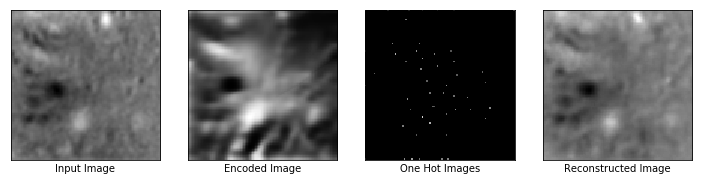

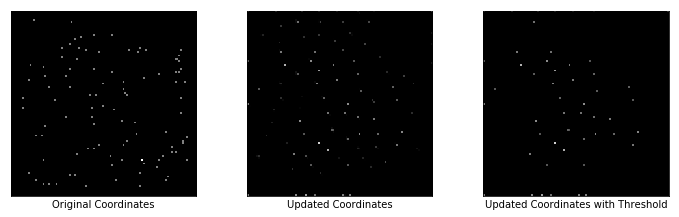

Epochs: 900, Session: 4
Reconstruction Loss: 0.0009784168796613812
Regularizer Loss: 368846.78125, Total Loss: 368846.78125
Encoder Loss: 3.7070488929748535
Max Similarity scores: 0.7832833528518677
Updated Coordinates: [[[0.5413581 0.6961585]]]
Gradient global min:-0.0030883722938597202, max:0.004260926507413387
Gradient encoder min:-1.1412791013717651, max:1.4317876100540161
Gradient learnable coords min:-2.833744110830594e-05, max:1.6179066733457148e-05



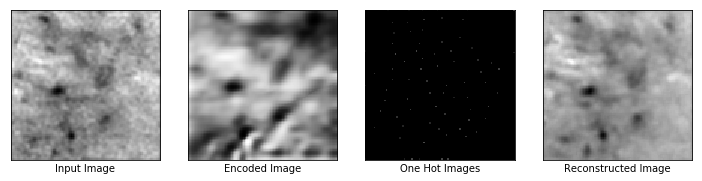

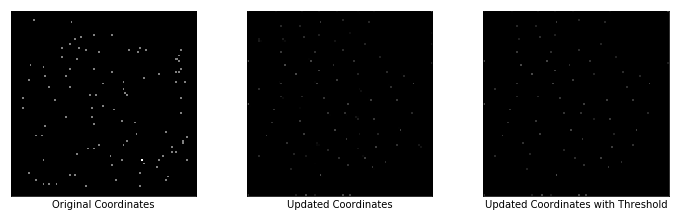

Epochs: 900, Session: 5
Reconstruction Loss: 0.0016386270290240645
Regularizer Loss: 367736.28125, Total Loss: 367736.28125
Encoder Loss: 6.952572822570801
Max Similarity scores: 0.9308515191078186
Updated Coordinates: [[[0.5346398  0.69820964]]]
Gradient global min:-0.00035791442496702075, max:0.0004861466004513204
Gradient encoder min:-2.5137009620666504, max:3.2553818225860596
Gradient learnable coords min:-4.371990871732123e-05, max:3.121902045677416e-05



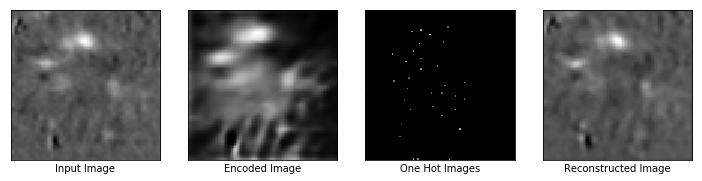

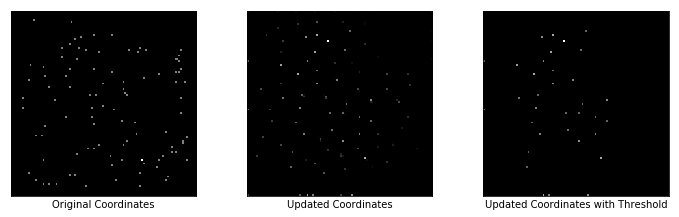

Epochs: 1000, Session: 0
Reconstruction Loss: 0.0008267132798209786
Regularizer Loss: 439781.5625, Total Loss: 439781.5625
Encoder Loss: 4.28289270401001
Max Similarity scores: 0.884463906288147
Updated Coordinates: [[[0.5140462  0.70702136]]]
Gradient global min:-0.0003798373800236732, max:0.0004051593423355371
Gradient encoder min:-1.2522932291030884, max:1.93001389503479
Gradient learnable coords min:-1.3104770914651453e-05, max:2.2096759494161233e-05



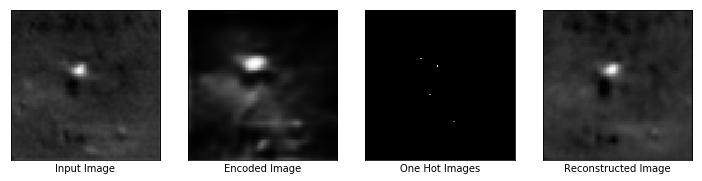

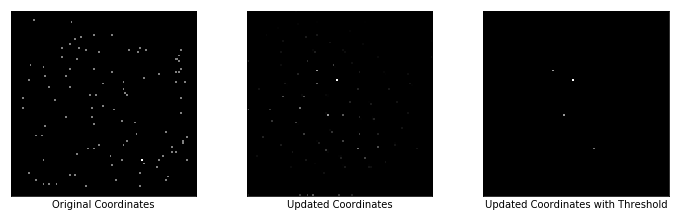

Epochs: 1000, Session: 1
Reconstruction Loss: 0.0007527701673097908
Regularizer Loss: 449923.59375, Total Loss: 449923.59375
Encoder Loss: 1.0690959692001343
Max Similarity scores: 0.6832491755485535
Updated Coordinates: [[[0.51409036 0.7070684 ]]]
Gradient global min:-0.0014274194836616516, max:0.0021307694260030985
Gradient encoder min:-0.3484242558479309, max:0.45427823066711426
Gradient learnable coords min:-1.2093615623598453e-05, max:5.057750968262553e-05



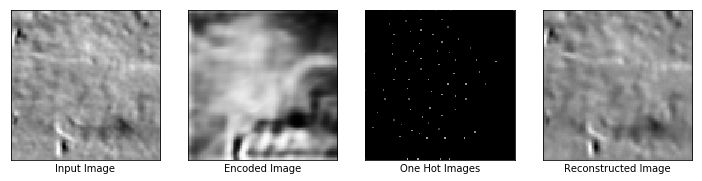

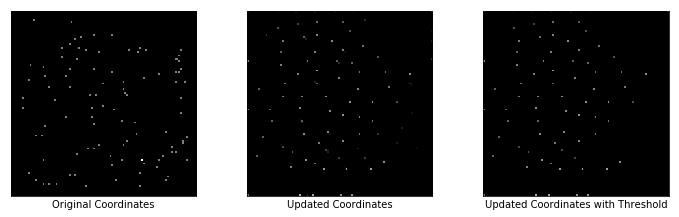

Epochs: 1000, Session: 2
Reconstruction Loss: 0.000919703277759254
Regularizer Loss: 445718.21875, Total Loss: 445718.21875
Encoder Loss: 7.705120086669922
Max Similarity scores: 0.9044312834739685
Updated Coordinates: [[[0.51473534 0.7069568 ]]]
Gradient global min:-0.0029370507691055536, max:0.004256034269928932
Gradient encoder min:-2.7491555213928223, max:3.729231834411621
Gradient learnable coords min:-8.604396498412825e-06, max:7.368439582933206e-06



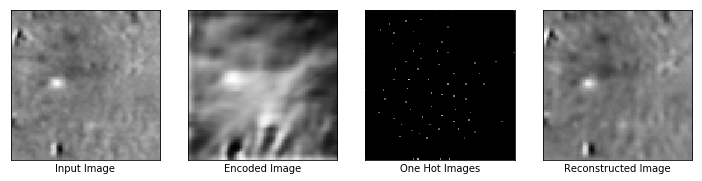

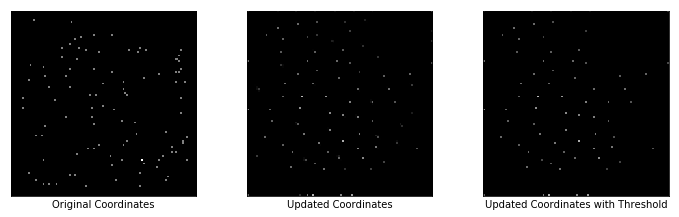

Epochs: 1000, Session: 3
Reconstruction Loss: 0.0006549093523062766
Regularizer Loss: 434501.09375, Total Loss: 434501.09375
Encoder Loss: 5.644449234008789
Max Similarity scores: 0.9037117958068848
Updated Coordinates: [[[0.51513124 0.7065267 ]]]
Gradient global min:-0.00039783347165212035, max:0.00041926285484805703
Gradient encoder min:-1.8925961256027222, max:2.7691566944122314
Gradient learnable coords min:-1.6946929463301785e-05, max:9.09189384401543e-06



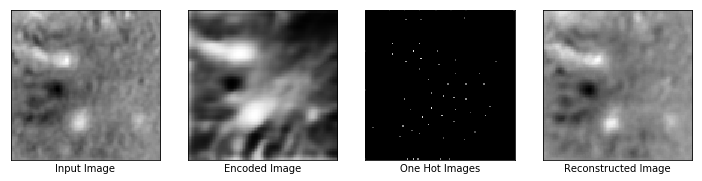

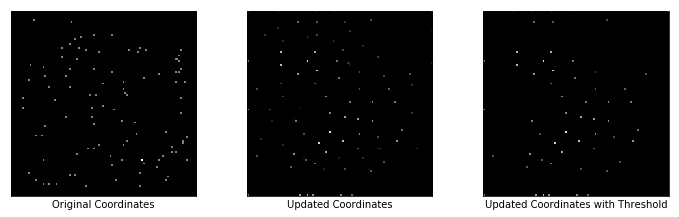

Epochs: 1000, Session: 4
Reconstruction Loss: 0.0008276125881820917
Regularizer Loss: 437573.0, Total Loss: 437573.0
Encoder Loss: 3.634737014770508
Max Similarity scores: 0.923822283744812
Updated Coordinates: [[[0.51411384 0.70611966]]]
Gradient global min:-0.0009360823896713555, max:0.0008899013046175241
Gradient encoder min:-1.0708928108215332, max:1.6235365867614746
Gradient learnable coords min:-9.227987902704626e-06, max:2.09608278964879e-05



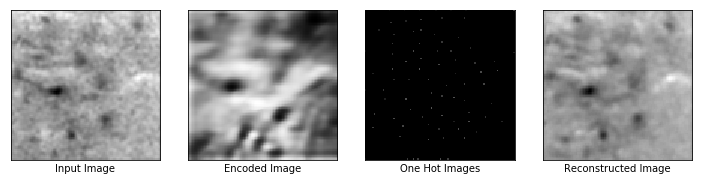

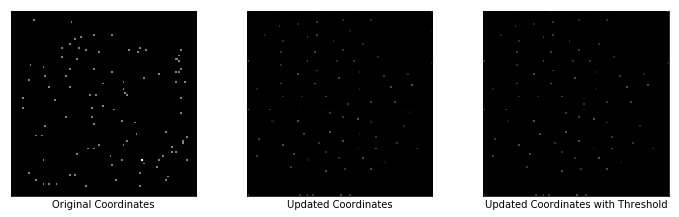

Epochs: 1000, Session: 5
Reconstruction Loss: 0.0015352051705121994
Regularizer Loss: 444288.8125, Total Loss: 444288.8125
Encoder Loss: 6.761797904968262
Max Similarity scores: 0.8858033418655396
Updated Coordinates: [[[0.51438123 0.7059875 ]]]
Gradient global min:-0.0001663798320805654, max:0.0001486325345467776
Gradient encoder min:-2.4473702907562256, max:3.4330012798309326
Gradient learnable coords min:-5.25685618413263e-06, max:1.72720701812068e-05


In [12]:
# batch_imgs= tf.data.Dataset.from_tensor_slices(re_list).batch(BATCH_SIZE, drop_remainder=True)
ds_dir = '/home/kevinteng/Desktop/jpg_to_npy_benchmark/'
#list to be append to output 
loss_list_global = []
loss_list_encoded_one_hot = []
regulariser_loss_list = []
input_imgs = []
coords_list = []
encoded_imgs = []
reconstructed_imgs = []
one_hot_imgs_list = []
similarity_list = []

captions_01 = ['Input Image', 'Encoded Image', 'One Hot Images','Reconstructed Image']
captions_02 = ['Original Coordinates', 'Updated Coordinates', 'Updated Coordinates with Threshold']

#list to append to monitor each frames for the last epochs 
one_hot_imgs_last_list = []
encoder_output_last_list = []
similarity_score_last_list = []
reconstruction_last_list = []

epochs = 1
#one epochs => loop through all sessions
while epochs <= MAX_EPOCHS:
    sess = 0
    #loops through all the sessions
    for session in sorted(os.listdir(ds_dir)):
        merge_sess = os.path.join(ds_dir+session)
        merge_sess = np.load(merge_sess)
        #resize the images
        re_list = utils.resize(merge_sess, NEW_SIZE)
        re_list = utils.min_max_norm(re_list)
        #add channel 
        re_list = np.expand_dims(re_list, axis = -1)
        re_list = tf.convert_to_tensor(re_list, dtype = tf.float32)
        batch_imgs= tf.data.Dataset.from_tensor_slices(re_list).batch(BATCH_SIZE, drop_remainder=True)
        #initialize list to store data for sessions in last epochs
        one_hot_imgs_last_sess = []
        encoder_output_last_sess = []
        similarity_score_last_sess = []
        reconstruction_last_sess = []
        #loss for each session
        loss_sess = [] #reconstruction loss
        reg_loss_sess = [] #regularizer loss
        enc_loss_sess = [] #ecnoder loss
        for batched_imgs in batch_imgs:
            loss, updated_coords, one_hot_imgs, encoder_output, similarity_score, reconstruction, grad = train_fn(batched_imgs, coords, 
                                                                                                                  IMG_SIZE, BATCH_SIZE,
                                                                                                                  neuron_multi = True,
                                                                                                                 one_hot_thr = True)
            #append all frames for final epochs per session!
            if epochs==MAX_EPOCHS:
                one_hot_imgs_last_sess.append(one_hot_imgs)
#                 encoder_output_last_sess.append(encoder_output)
                similarity_score_last_sess.append(similarity_score)
#                 reconstruction_last_sess.append(reconstruction)
        
        #append all sessions for final epochs!
        if epochs==MAX_EPOCHS:
            one_hot_imgs_last_list.append(one_hot_imgs_last_sess)
#             encoder_output_last_list.append(encoder_output_last_sess)
            similarity_score_last_list.append(similarity_score_last_sess)
#             reconstruction_last_list.append(reconstruction_last_sess)


        if epochs%100==0:
            rand = randint(0, BATCH_SIZE-1) #random number to generate for plotting outputs 
            img_row01 = [batched_imgs[rand], encoder_output[rand], similarity_multi(one_hot_imgs, similarity_score, thr=thr)[rand], reconstruction[rand]]
            img_row02 = [stack4plot(ori_one_hot_imgs), similarity_multi(one_hot_imgs, similarity_score)[rand], similarity_multi(one_hot_imgs, similarity_score, thr=thr)[rand]]
            plot_comparison(img_row01, captions_01, n_col=len(img_row01), figsize = (10, 10))
            plot_comparison(img_row02, captions_02, n_col=len(img_row02), figsize = (10, 10))
            #print for each session in the epochs 
            #note for loss indices
            #loss = [global_loss, encoded_dummy, regularizer_loss, total_loss]
            print("Epochs: {}, Session: {}".format(epochs, sess))
            print("Reconstruction Loss: {}".format(loss[0].numpy()))
            print("Regularizer Loss: {}, Total Loss: {}".format(loss[2].numpy(), loss[-1].numpy()))
            print("Encoder Loss: {}".format(loss[1].numpy()))
            print("Max Similarity scores: {}".format(np.max(similarity_score[rand])))
            print("Updated Coordinates: {}".format(updated_coords[0]))
            print("Gradient global min:{}, max:{}".format(np.min(grad[0][rand]), np.max(grad[0][rand])))
            print("Gradient encoder min:{}, max:{}".format(np.min(grad[1][0]), np.max(grad[1][0])))
            print("Gradient learnable coords min:{}, max:{}".format(np.min(grad[2][0]), np.max(grad[2][0])))
            #append to list 
            encoded_imgs.append(encoder_output)
            input_imgs.append(batched_imgs)
            coords_list.append(updated_coords)
            reconstructed_imgs.append(reconstruction)
            one_hot_imgs_list.append(one_hot_imgs)
            similarity_list.append(similarity_score)
        
        sess+=1
        #append all losses for each session
        loss_sess.append(loss[0])
        reg_loss_sess.append(loss[1])
        enc_loss_sess.append(loss[-1])
    #loss is append for each epochs
    loss_list_global.append(np.mean(np.array(loss_sess)))
    loss_list_encoded_one_hot.append(np.mean(np.array(reg_loss_sess)))
    regulariser_loss_list.append(np.mean(np.array(enc_loss_sess)))
    #increment epochs
    epochs+=1

----

# Save Output Data

In [13]:
save_list = [loss_list_global, loss_list_encoded_one_hot, input_imgs, coords_list, encoded_imgs, reconstructed_imgs, one_hot_imgs_list, similarity_list]
save_names = ['loss_list_global', 'loss_list_encoded_one_hot', 'input_imgs', 'coords_list', 'encoded_imgs', 'reconstructed_imgs', 'one_hot_imgs_list', 'similarity_list']

directory = '/home/kevinteng/Desktop/npy/{}'.format(ver)
#make directory to save
if not os.path.exists(directory):
    os.makedirs(directory)
    
for names, items in zip(save_names, save_list):
    tensor = tf.convert_to_tensor(items, tf.float32)
    np.save(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, names, ver), np.array(tensor))
    

In [14]:
#save coords and one hot images()
np.save(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'ori_coords', ver), np.array(coords))
np.save(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'ori_one_hot_imgs', ver), np.array(ori_one_hot_imgs))

In [15]:
ds_dir = '/home/kevinteng/Desktop/jpg_to_npy_benchmark/'
store_name = [d.split(".")[0] for d in sorted(os.listdir(ds_dir))]
#intended save path 
int_save_path = path_desktop+'npy/{}/sim_one_{}'.format(ver, ver)
#create new file to store sim score and one hot images for last frames
if not os.path.exists(int_save_path):
    os.makedirs(int_save_path)

#save sim scores for every session in last epochs 
similarity_score_last_list = utils.concat_batch(similarity_score_last_list) #(sess, frames, n_neurons)
for idx, stack in enumerate(similarity_score_last_list):
    np.save(int_save_path+'/sim_last_{}_{}.npy'.format(store_name[idx], ver), np.array(stack))

In [16]:
#save one hot imgs for last epochs 
for idx,stack in enumerate(one_hot_imgs_last_list):
    tensor = tf.convert_to_tensor(stack, tf.float32) #(frames/batch, n_neurons, img_size, img_size, 1)
    np.save(int_save_path+'/one_last_{}_{}.npy'.format(store_name[idx], ver), np.array(tensor))

In [38]:
# #save info for every frames in last epochs
# save_list_last = [encoder_output_last_list, similarity_score_last_list, reconstruction_last_list]
# save_names_last = ['encoder_output_last_list', 'similarity_score_last_list', 'reconstruction_last_list']

# for names, items in zip(save_names_last, save_list_last):
#     aggregate_tensor = utils.concat_batch(items)
#     np.save(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, names, ver), np.array(aggregate_tensor))

In [47]:
#save one hot imgs for last epochs 
# tensor = tf.convert_to_tensor(one_hot_imgs_last_list, tf.float32) #(frames/batch, n_neurons, img_size, img_size, 1)
# np.save(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'one_hot_imgs_last_list', ver), np.array(tensor))

In [ ]:
#save one hot imgs for last epochs 
# tensor = tf.convert_to_tensor(one_hot_imgs_last_list, tf.float32) #(frames/batch, n_neurons, img_size, img_size, 1)
# np.save(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'one_hot_imgs_last_list', ver), np.array(tensor))

In [17]:
#save weights
encoder_model.save_weights('model_weights/encoder_model_{}.h5'.format(ver))
decoder_model.save_weights('model_weights/decoder_model_{}.h5'.format(ver))

---

# Visualization

In [4]:
# coords list for every 100 epochs (max_epochs/100, n_neurons, 1, 1, 2)
coords_list_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'coords_list', ver)) 
# encoder output first batch for every 100 epochs (max_epochs/100, 8, 100, 100, 1)
encoded_imgs_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'encoded_imgs', ver))
# input image first batch for every 100 epochs (max_epochs/100, 8, 100, 100, 1)
input_imgs_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'input_imgs', ver))
# global loss for every epochs
loss_list_global_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'loss_list_global', ver))
#similarity loss for every epochs
loss_list_encoded_one_hot_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'loss_list_encoded_one_hot', ver))
# one hot images first batch for every 100 epochs  (max_epochs/100, n_neurons, 100, 100, 1)
one_hot_imgs_list_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'one_hot_imgs_list', ver))
# reconstructed images first batch for every 100 epochs (max_epochs/100, 8, 100, 100, 1)
reconstructed_imgs_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'reconstructed_imgs', ver))
# similarity batch for every 100 epochs (max_epochs/100, 8, n_neurons)
similarity_list_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'similarity_list', ver))
#original coords list (n_neurons, 1, 1, 2)
ori_coords_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'ori_coords', ver))
#original one hot image (n_neurons, 100, 100, 1)
ori_one_hot_imgs_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'ori_one_hot_imgs', ver))

In [4]:
#load roi mask
roi_img = np.load('/home/kevinteng/Desktop/Manual_annotation/DG-13-3-8-17_ROImask.npy')
roi_img = cv2.resize(roi_img, (100, 100))
# plt.imshow(roi_img, cmap = 'gray')

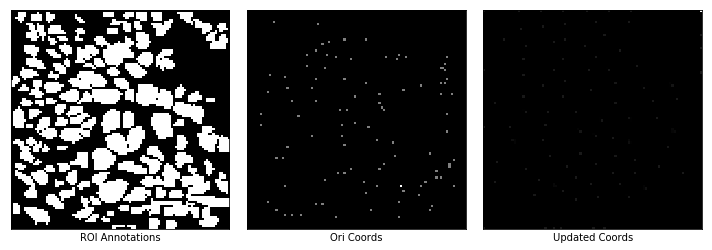

In [5]:
#comparison of roi and one hot images 
captions_03 = ['ROI Annotations', 'Ori Coords', 'Updated Coords']
img_row03 = [roi_img, stack4plot(ori_one_hot_imgs_npy), stack4plot(one_hot_imgs_list_npy[-1])]
plot_comparison(img_row03, captions_03, n_col=len(img_row03), figsize = (10, 10))

Mean value:  0.01
Counts:  94


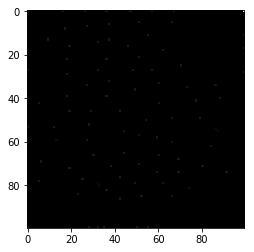

In [12]:
sum_updated_coords = stack4plot(one_hot_imgs_list_npy[-1])
print("Mean value: ", np.mean(sum_updated_coords))
updated_coords_img = np.where(sum_updated_coords<thr, 0, sum_updated_coords) 
activations_count = np.count_nonzero(updated_coords_img!=0)
print("Counts: ", activations_count)
plt.imshow(updated_coords_img, cmap = 'gray')

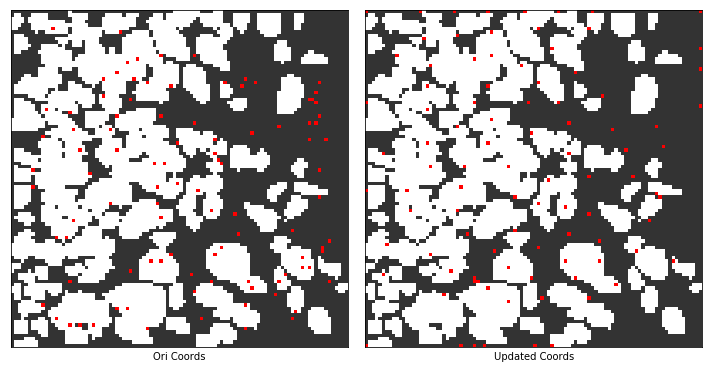

In [13]:
#define color
col = [(0.2, 0.2, 0.2),(1,1,1),(1,0,0)] 
cm = LinearSegmentedColormap.from_list('mylist', col, 3)  
#     #Bins for cmap
bounds=[0,1,5,10]
norm = BoundaryNorm(bounds, cm.N)
#overlap mask with original coordinates 
roi_ori_mask = overlapMasks02(roi_img, stack4plot(ori_one_hot_imgs_npy))

#overlap mask with updated coordinates 
roi_updated_mask = overlapMasks02(roi_img, updated_coords_img)

captions_04 = ['Ori Coords', 'Updated Coords']
img_row04 = [roi_ori_mask, roi_updated_mask]
plot_comparison(img_row04, captions_04, n_col=len(img_row04), figsize = (10, 10), cmap = cm, norm = norm)

In [24]:
#confusion matrix 
confMatrix = utils_model.getConfusionMatrix(roi_img, updated_coords_img)

print("True Positives: ", confMatrix[0])
print("True Negatives: ", confMatrix[1])
print("False Positive Ratio: ", confMatrix[2])
print("False Negatives Ratio: ", confMatrix[3])
print("F1 score: ", utils_model.f1score(confMatrix))

True Positives:  0.0038
True Negatives:  0.007
False Positive Ratio:  0.4148
False Negatives Ratio:  0.5744
F1 score:  0.017699115044247787


---

# Similarity Scores with Threshold

In [8]:
neuron_activations, neuron_activations_thr = similarity_multiplication(similarity_list_npy, one_hot_imgs_list_npy, 
                                                                       n_neurons, epoch_pos=-1, 
                                                                       img_size = IMG_SIZE, threshold = 0.7)

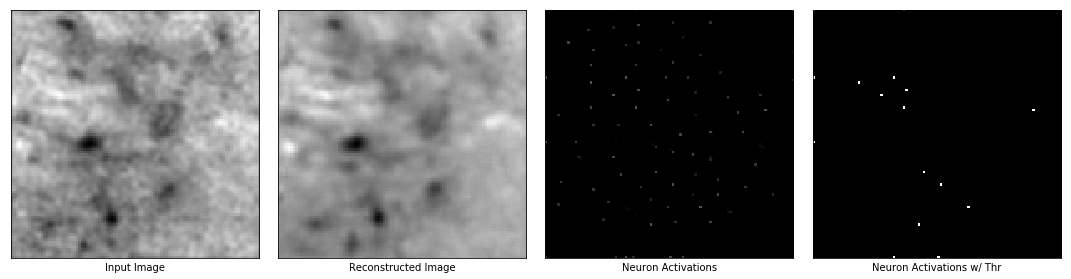

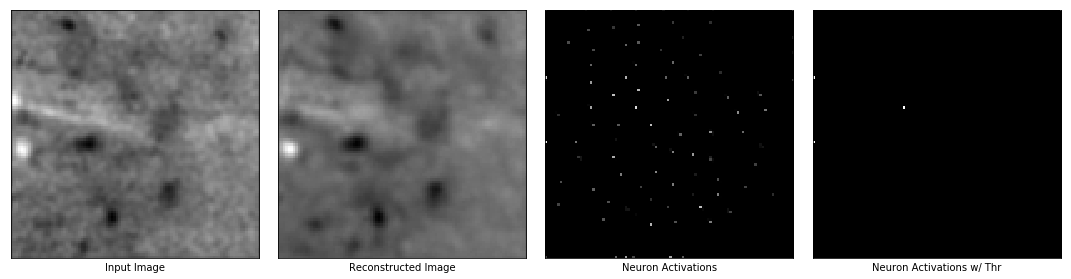

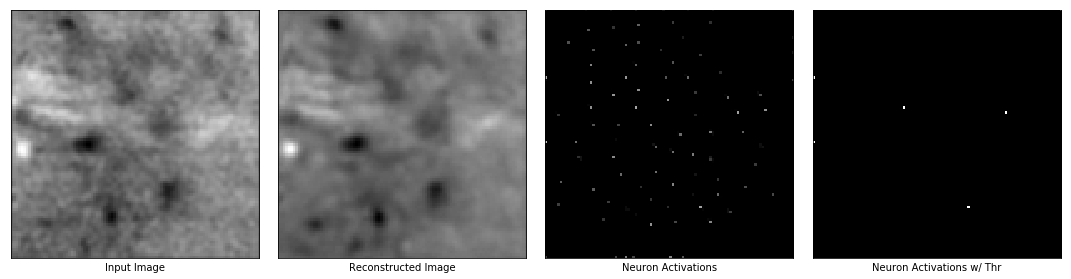

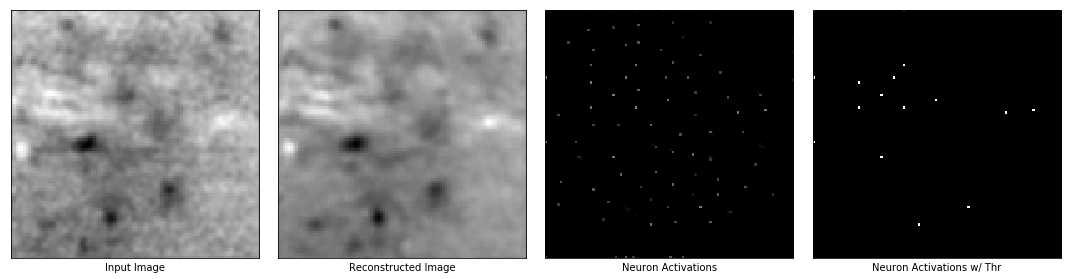

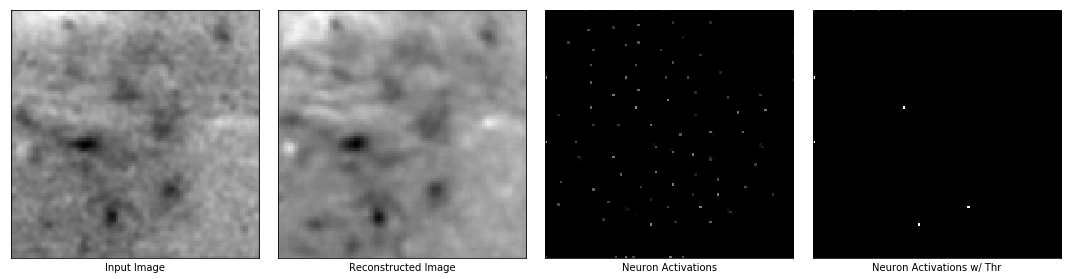

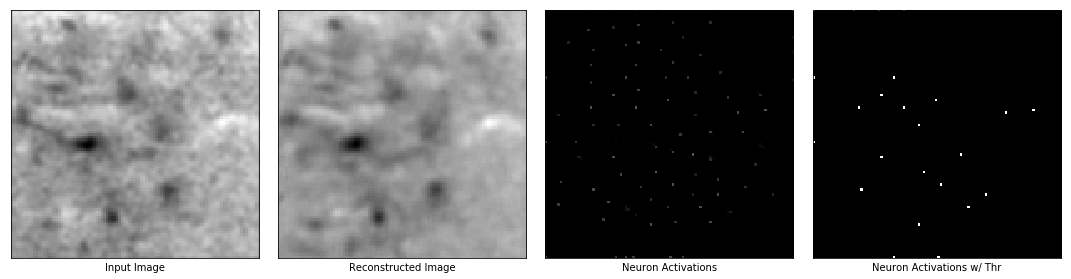

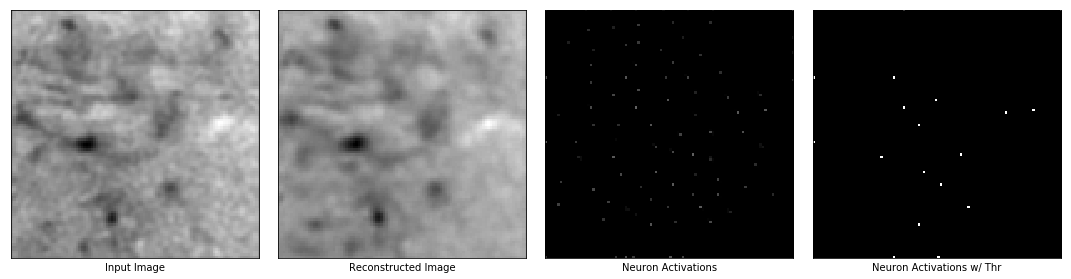

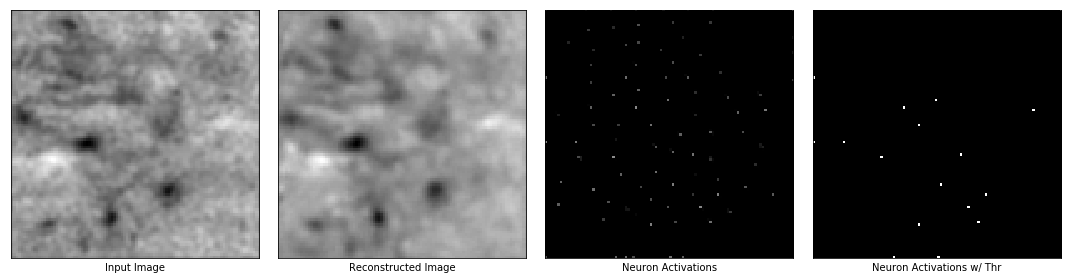

In [9]:
batch_size = BATCH_SIZE
captions_03 = ['Input Image', 'Reconstructed Image','Neuron Activations', 'Neuron Activations w/ Thr']
for i in range(batch_size):
    img_row03 = [np.squeeze(input_imgs_npy[-1,i]), np.squeeze(reconstructed_imgs_npy[-1,i]), neuron_activations[i], neuron_activations_thr[i]]
    plot_comparison(img_row03, captions_03, n_col=len(img_row03), figsize = (15, 15))

## Loss Plot

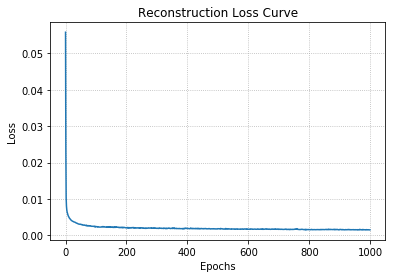

In [15]:
#plot loss
xlabel = 'Epochs'
ylabel = 'Loss'
title = 'Reconstruction Loss Curve'
utils_vis.plot_loss(loss_list_global_npy, xlabel, ylabel, title)

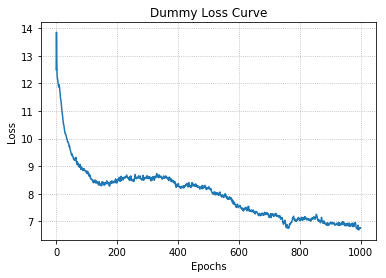

In [16]:
#plot loss
xlabel = 'Epochs'
ylabel = 'Loss'
title = 'Dummy Loss Curve'
utils_vis.plot_loss(loss_list_encoded_one_hot_npy, xlabel, ylabel, title)

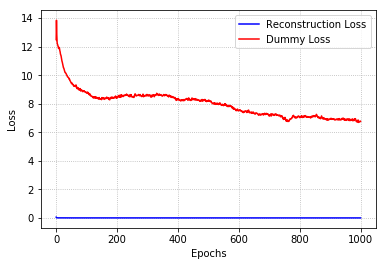

In [14]:
plt.plot(loss_list_global_npy, color='b', label='Reconstruction Loss')
plt.plot(loss_list_encoded_one_hot_npy, color='r', label='Dummy Loss')
plt.legend(loc='upper right')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(linestyle='dotted')
plt.show()

## Feature Maps

In [12]:
#build encoder 
inps = Input(shape=(IMG_SIZE, IMG_SIZE, 1))
encoder_model = Model(inps, encoder(inps, IMG_SIZE))
encoder_model.load_weights("model_weights/encoder_model_{}.h5".format(ver))
#build coord model
inp = Input(shape=(100, 100,2)) #(batch_size, img_size, img_size, 2)
de_coordconv = Model(inp, de_conv(inp))
de_coordconv.load_weights("best_class_model100_02.hdf5")

#decoder
latent_dim = Input(shape=(n_neurons, 3, 1))
decoder_model = Model(latent_dim, decoder(latent_dim))
decoder_model.load_weights("model_weights/decoder_model_{}.h5".format(ver))

#learnable coords
l_coords = learnable_coords(ori_coords_npy)

In [29]:
decoder_layers_name = utils_vis.layers_name(decoder_model) 

input_6
flatten_3
dense_1
reshape_1
up_sampling2d_6
coord_conv_7
activation_2
up_sampling2d_7
conv2d_32
activation_3
conv2d_33


In [30]:
#concat latent space as input
squeeze_coords = np.squeeze(coords_list_npy[-1]) #use the last pos
similarity_score = similarity_list_npy[-1]


concat = tf.stack((squeeze_coords[:,-2], squeeze_coords[:,-1], similarity_score[0]), axis=-1)
concat_ex = concat[np.newaxis,:,:,np.newaxis] #extand axis=0 and axis=-1 for input into model
print(concat_ex.shape)

(1, 100, 3, 1)


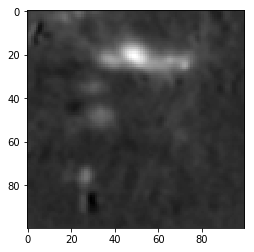

In [31]:
plt.imshow(np.squeeze(input_imgs_npy[-1,0]), cmap = 'gray')

Shape of feature maps: (1, 50, 50, 64)
Number of feature maps in layer:  64


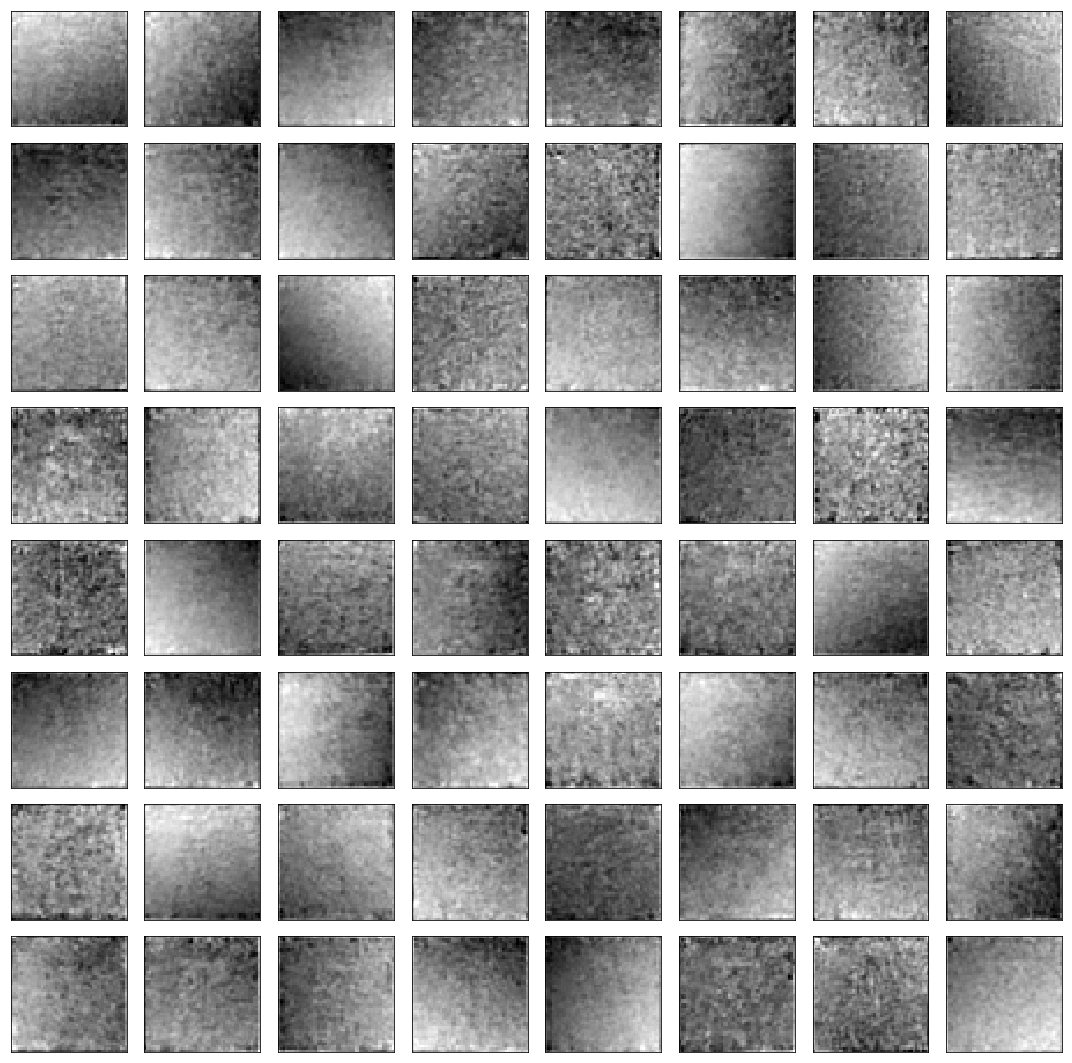

In [33]:
coord_conv_feature_maps = utils_vis.feature_maps(decoder_model, 'coord_conv_7', concat_ex)
utils_vis.plot_feature_maps(coord_conv_feature_maps, 8, 8, figsize=(15,15))

Shape of feature maps: (1, 100, 100, 32)
Number of feature maps in layer:  32


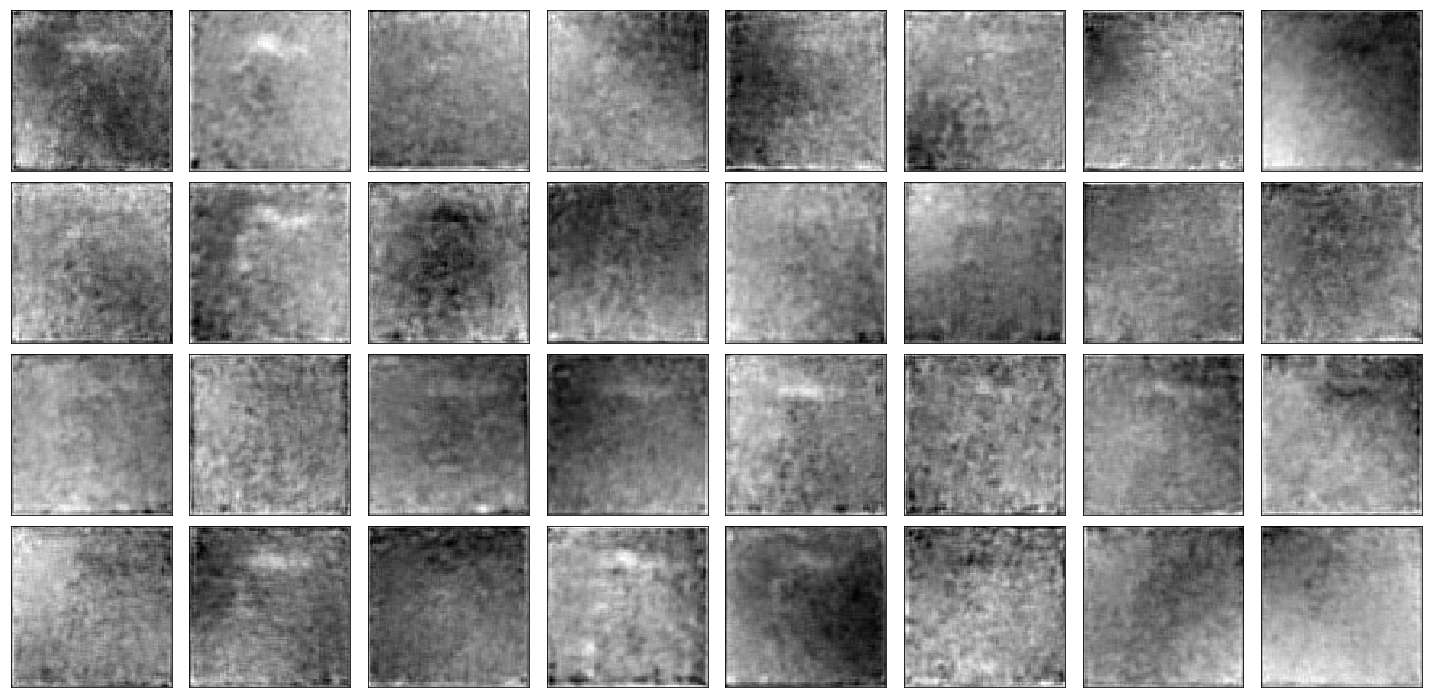

In [34]:
coord_conv_feature_maps = utils_vis.feature_maps(decoder_model, 'conv2d_32', concat_ex)
utils_vis.plot_feature_maps(coord_conv_feature_maps, 4, 8, figsize=(20,10))

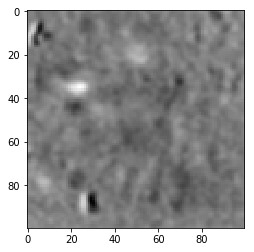

In [35]:
plt.imshow(np.squeeze(input_imgs_npy[-1,5]), cmap = 'gray')

In [36]:
#concat latent space as input
squeeze_coords = np.squeeze(coords_list_npy[-1]) #use the last pos
similarity_score = similarity_list_npy[-1]


concat = tf.stack((squeeze_coords[:,-2], squeeze_coords[:,-1], similarity_score[5]), axis=-1)
concat_ex = concat[np.newaxis,:,:,np.newaxis] #extand axis=0 and axis=-1 for input into model
print(concat_ex.shape)

(1, 100, 3, 1)


Shape of feature maps: (1, 50, 50, 64)
Number of feature maps in layer:  64


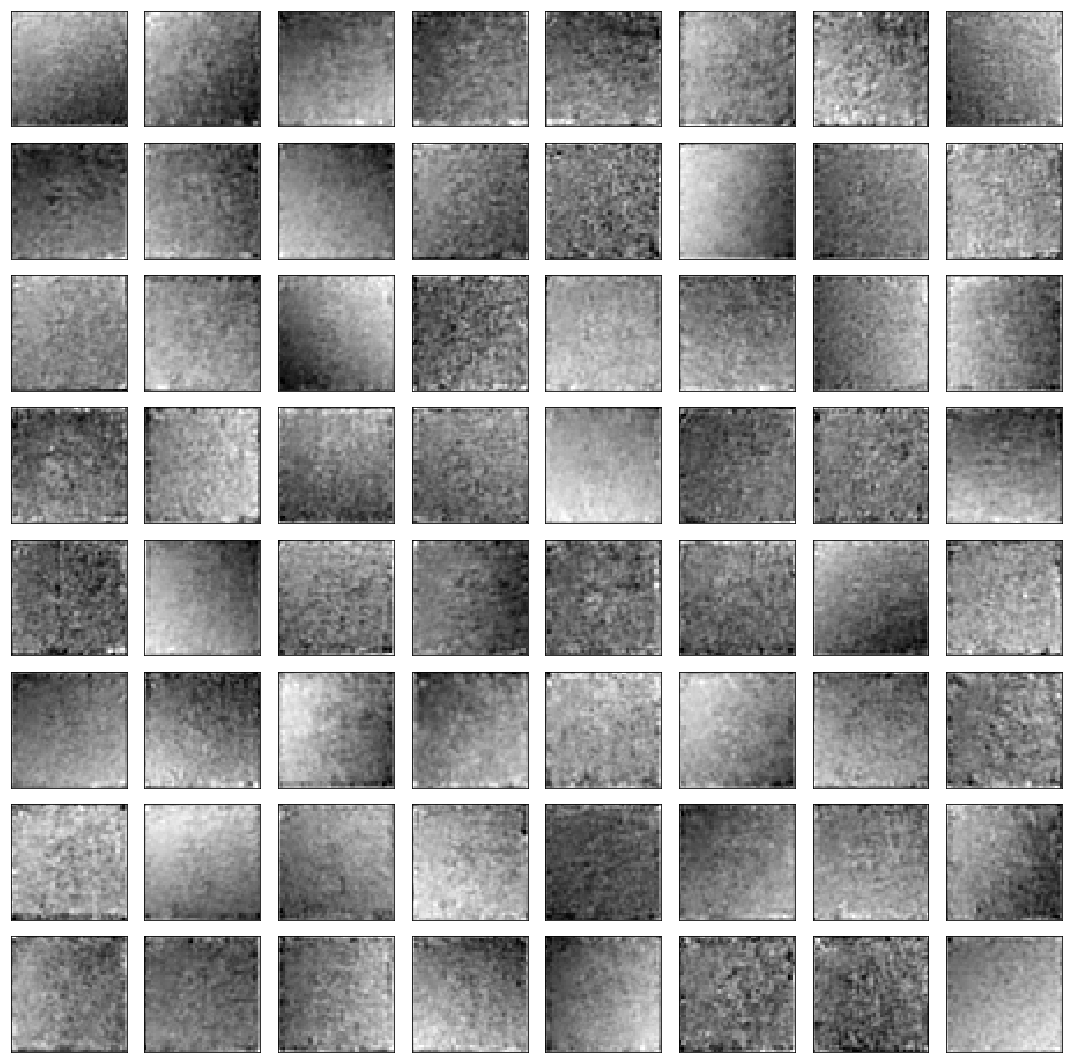

In [37]:
coord_conv_feature_maps = utils_vis.feature_maps(decoder_model, 'coord_conv_7', concat_ex)
utils_vis.plot_feature_maps(coord_conv_feature_maps, 8, 8, figsize=(15,15))

Shape of feature maps: (1, 100, 100, 32)
Number of feature maps in layer:  32


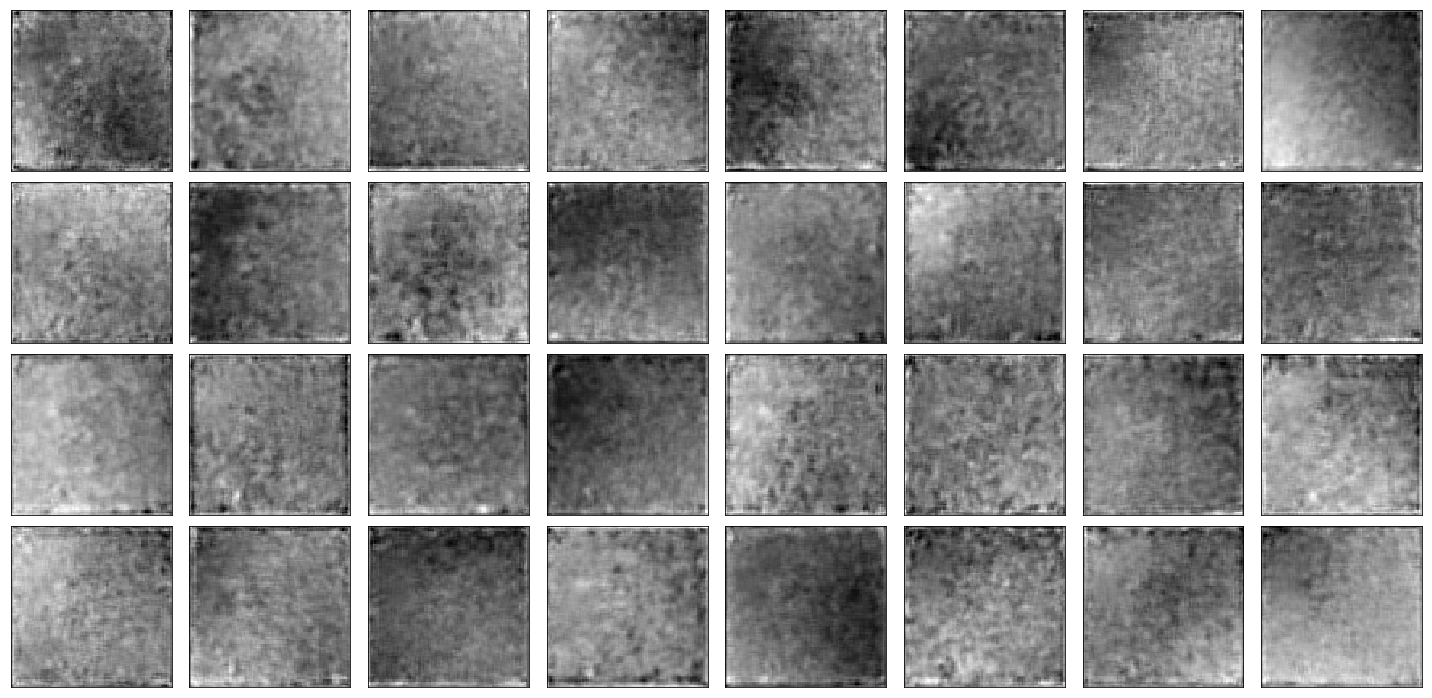

In [38]:
coord_conv_feature_maps = utils_vis.feature_maps(decoder_model, 'conv2d_32', concat_ex)
utils_vis.plot_feature_maps(coord_conv_feature_maps, 4, 8, figsize=(20,10))

---

# Visualization Per-frame

In [13]:
# one_hot_imgs_last_list_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'one_hot_imgs_last_list', ver))
# encoder_output_last_list_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'encoder_output_last_list', ver))
# similarity_score_last_list_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'similarity_score_last_list', ver))
# reconstruction_last_list_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'reconstruction_last_list', ver))

In [7]:
load_path = '/home/kevinteng/Desktop/npy/fullSess04/sim_one_fullSess04/'
roi_path = '/home/kevinteng/Desktop/Manual_annotation/'
one_hot_npy_list = [l for l in sorted(os.listdir(load_path+'one_hot/'))]
sim_npy_list = [l for l in sorted(os.listdir(load_path+'sim_last/'))]
roi_npy_list = [l for l in sorted(os.listdir(roi_path))]

In [8]:
ds_dir = '/home/kevinteng/Desktop/jpg_to_npy_benchmark/'
for session in sorted(os.listdir(ds_dir)):
    print(session)

DG13_3-8-17_preprocessed_dF.npy
DG13_7-12-17_preprocessed_dF.npy
DG13_8-11-17_preprocessed_dF.npy
DG13_8-16-17_preprocessed_dF.npy
DG13_8-18-17_preprocessed_dF.npy
DG13_8-8-17_preprocessed_dF.npy


In [5]:

def multi_similarity_frame(one_hot_imgs_last_list_npy, similarity_score_last_list_npy, img_size, batch_size):
    '''
    Multiply similarity scores for every one hot pixel images and aggregate the one hot images into
    single frames
    
    @param one_hot_imgs_last_list_npy: .npy array of one hot images for the last epochs 
    @param similarity_score_last_list_npy: .npy array of similarity score for the last epochs
    @param img_size: image size
    @param batch_size: batch size
    
    return 
    tensor of one hot images multiplied with similarity scores for each images 
    '''
    count = 0
    onehot_list = []
    for one_hot in np.squeeze(one_hot_imgs_last_list_npy):
        if count!=len(similarity_score_last_list_npy): 
            for idx in range(count,count+batch_size): #loop through the similarity score for every batch_size increment
                sum_multi = np.zeros((img_size, img_size))
                for n in range(len(one_hot)): #n_neurons
                    multi = similarity_score_last_list_npy[idx, n]*one_hot[n]
                    sum_multi+=multi #sum all the one hot images
                onehot_list.append(sum_multi)
        count+=batch_size
        tensor = tf.convert_to_tensor(onehot_list, tf.float32)
    
    return tensor

In [25]:
# one_hot_imgs_last_list_npy = np.load(load_path+"{}/{}".format('one_hot', one_hot_npy_list[0]))
# similarity_score_last_list_npy = np.load(load_path+"{}/{}".format('sim_last',sim_npy_list[0]))
# tensor = multi_similarity_frame(one_hot_imgs_last_list_npy, similarity_score_last_list_npy, IMG_SIZE, BATCH_SIZE)

## Maximum Intensity Projection

In [96]:
# plt_captions = ['Original Coordinates', 'Maximum Intensity Projection']
# plt_row = [stack4plot(ori_one_hot_imgs_npy), np.where(np.sum(tensor, axis=0)<0.8, 0, 1.0)]

# plot_comparison(plt_row , plt_captions, n_col=len(plt_row), figsize = (15, 15))

DG-13-3-8-17_ROImask.npy
True Positives:  0.5092838196286472
False Positives:  0.4907161803713528
False Negatives:  0.4150472825522186
True Negatives:  0.5849527174477813
TP_total:  192
FP_total:  185
FN_total:  3994
F1 score:  0.5293099706713363


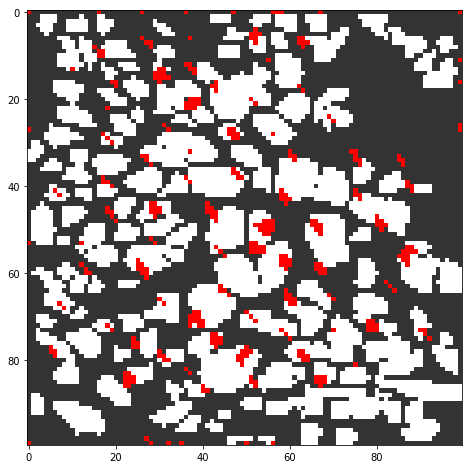

DG-13-7-12-17_ROImask.npy
True Positives:  0.2971014492753623
False Positives:  0.7028985507246377
False Negatives:  0.22459893048128343
True Negatives:  0.7754010695187166
TP_total:  82
FP_total:  194
FN_total:  2184
F1 score:  0.3904861341006901


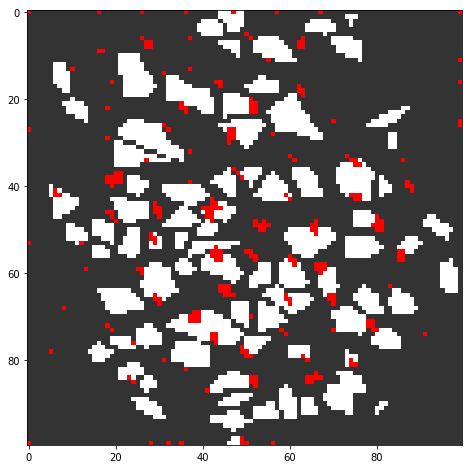

DG-13-8-11-17_ROImask.npy
True Positives:  0.4966216216216216
False Positives:  0.5033783783783784
False Negatives:  0.48330585325638914
True Negatives:  0.5166941467436108
TP_total:  147
FP_total:  149
FN_total:  4690
F1 score:  0.5016563767339205


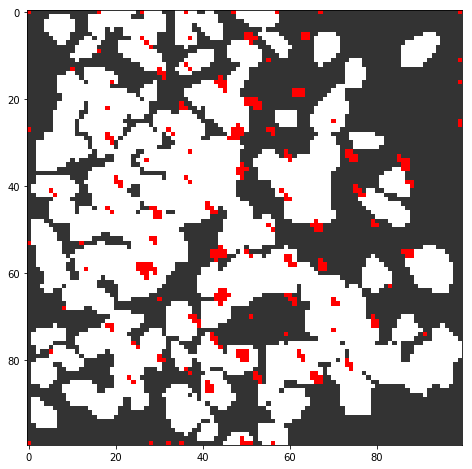

DG-13-8-16-17_ROImask.npy
True Positives:  0.5367647058823529
False Positives:  0.4632352941176471
False Negatives:  0.49321546052631576
True Negatives:  0.5067845394736843
TP_total:  146
FP_total:  126
FN_total:  4798
F1 score:  0.5288373894134819


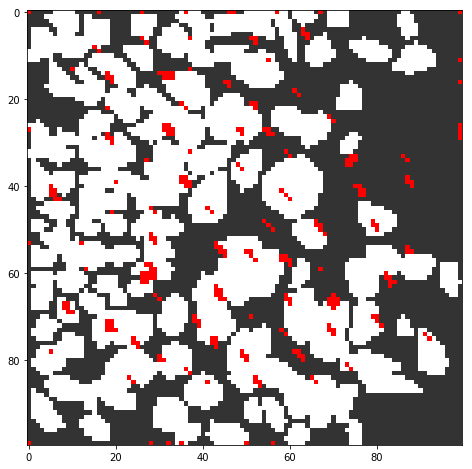

DG-13-8-8-17_ROImask.npy
True Positives:  0.421455938697318
False Positives:  0.578544061302682
False Negatives:  0.401581271177739
True Negatives:  0.598418728822261
TP_total:  110
FP_total:  151
FN_total:  3911
F1 score:  0.4623667980163748


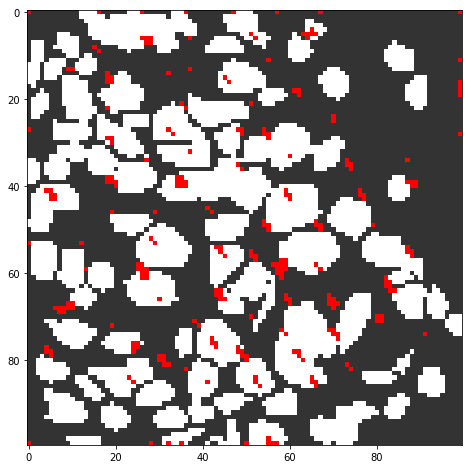

Dg-13-8-18-17_ROImask.npy
True Positives:  0.5062240663900415
False Positives:  0.49377593360995853
False Negatives:  0.4972845578440414
True Negatives:  0.5027154421559585
TP_total:  122
FP_total:  119
FN_total:  4853
F1 score:  0.5053375466088297


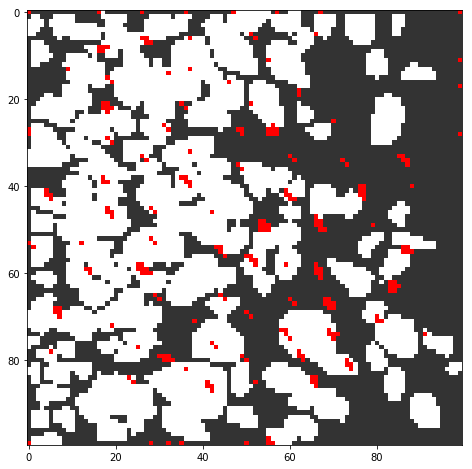

In [18]:
#define color
col = [(0.2, 0.2, 0.2),(1,1,1),(1,0,0)] 
cm = LinearSegmentedColormap.from_list('mylist', col, 3)  
#     #Bins for cmap
bounds=[0,1,5,10]
norm = BoundaryNorm(bounds, cm.N)
#loop through the session
for one_hot, sim_score, roi in zip(one_hot_npy_list, sim_npy_list, roi_npy_list):
    one_hot_imgs_last_list_npy = np.load(load_path+"{}/{}".format('one_hot', one_hot))
    similarity_score_last_list_npy = np.load(load_path+"{}/{}".format('sim_last',sim_score))
    roi_img = np.load(roi_path+roi)
    roi_img = cv2.resize(roi_img, (IMG_SIZE, IMG_SIZE))
    tensor = multi_similarity_frame(one_hot_imgs_last_list_npy, similarity_score_last_list_npy, IMG_SIZE, BATCH_SIZE)
    plt.figure(figsize=(8,8))
    tensor_sum02 = np.where(np.sum(tensor, axis=0)<0.8, 0, 1.0)
    roi_frame = overlapMasks02(roi_img, tensor_sum02)
    plt.imshow(roi_frame, cmap = cm , norm = norm)
    print(roi)
    confMatrix = utils_model.getConfusionMatrix(roi_img, tensor_sum02)
    print("True Positives: ", confMatrix[0])
    print("False Positives: ", confMatrix[1])
    print("False Negatives: ", confMatrix[2])
    print("True Negatives: ", confMatrix[3])
    print("TP_total: ", confMatrix[4])
    print("FP_total: ", confMatrix[5])
    print("FN_total: ", confMatrix[6])
    print("F1 score: ", utils_model.f1score(confMatrix))
    plt.show()

In [14]:
# #overlap mask with original coordinates 
# roi_ori_mask = overlapMasks02(roi_img, stack4plot(ori_one_hot_imgs_npy))

# captions_05 = ['Ori Coords', 'Similarity for Each Frames']
# img_row05 = [roi_ori_mask, roi_frame]
# plot_comparison(img_row05, captions_05, n_col=len(img_row05), figsize = (15, 15), cmap = cm, norm = norm)

# activations_count = np.count_nonzero(tensor_sum02!=0)
# print("Counts: ", activations_count)

DG-13-3-8-17_ROImask.npy
True Positives:  0.37373737373737376
False Positives:  0.6262626262626263
False Negatives:  0.41904858095141906
True Negatives:  0.5809514190485809
TP_total:  37
FP_total:  62
FN_total:  4149
F1 score:  0.41693474088182525


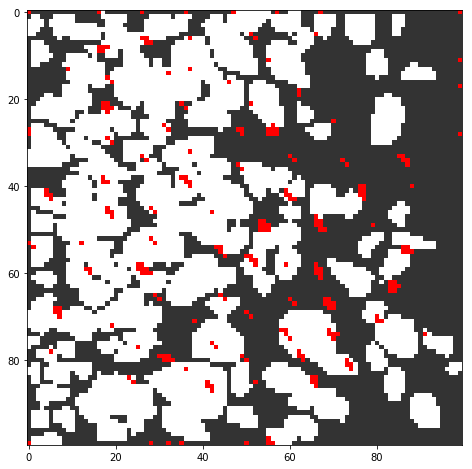

DG-13-7-12-17_ROImask.npy
True Positives:  0.20202020202020202
False Positives:  0.797979797979798
False Negatives:  0.22684577315422685
True Negatives:  0.7731542268457732
TP_total:  20
FP_total:  79
FN_total:  2246
F1 score:  0.28276998057223723


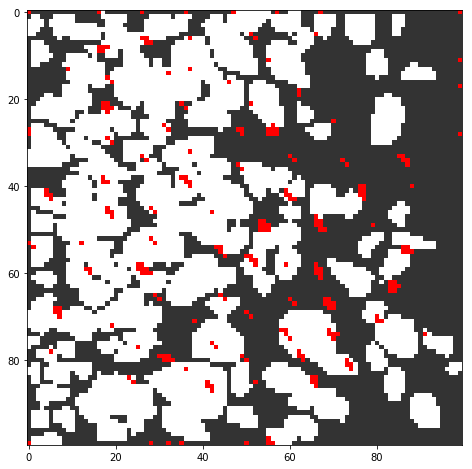

DG-13-8-11-17_ROImask.npy
True Positives:  0.494949494949495
False Positives:  0.5050505050505051
False Negatives:  0.4835875164124836
True Negatives:  0.5164124835875163
TP_total:  49
FP_total:  50
FN_total:  4788
F1 score:  0.5003186618265819


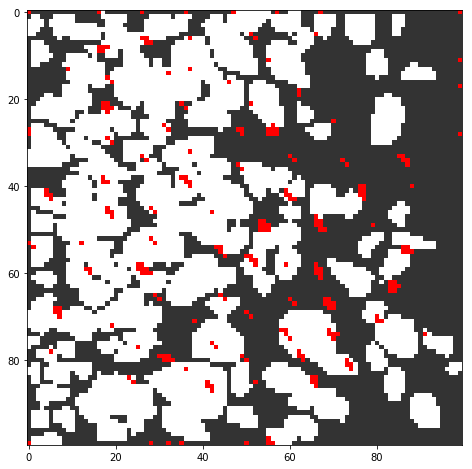

DG-13-8-16-17_ROImask.npy
True Positives:  0.5252525252525253
False Positives:  0.47474747474747475
False Negatives:  0.4940915059084941
True Negatives:  0.505908494091506
TP_total:  52
FP_total:  47
FN_total:  4892
F1 score:  0.5202209402134732


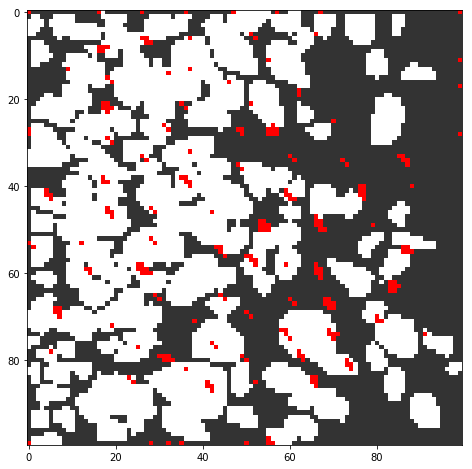

DG-13-8-8-17_ROImask.npy
True Positives:  0.43434343434343436
False Positives:  0.5656565656565656
False Negatives:  0.4017775982224018
True Negatives:  0.5982224017775982
TP_total:  43
FP_total:  56
FN_total:  3978
F1 score:  0.4731098077303469


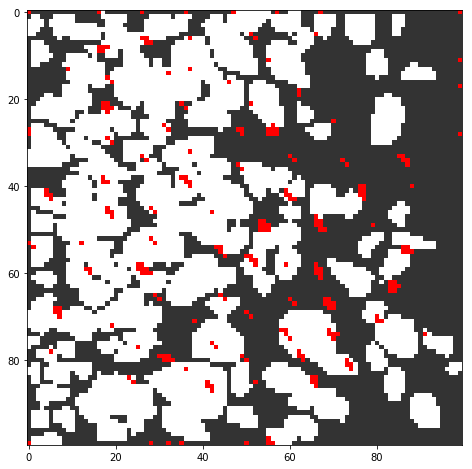

Dg-13-8-18-17_ROImask.npy
True Positives:  0.5050505050505051
False Positives:  0.494949494949495
False Negatives:  0.4974245025754974
True Negatives:  0.5025754974245026
TP_total:  50
FP_total:  49
FN_total:  4925
F1 score:  0.5044262756110584


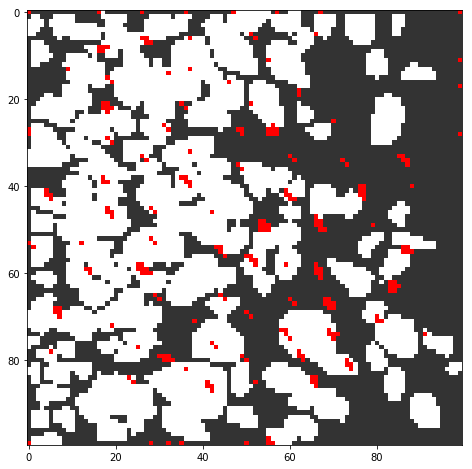

In [16]:
ori_onehot_imgs = stack4plot(ori_one_hot_imgs_npy)

for one_hot, sim_score, roi in zip(one_hot_npy_list, sim_npy_list, roi_npy_list):
    one_hot_imgs_last_list_npy = np.load(load_path+"{}/{}".format('one_hot', one_hot))
    similarity_score_last_list_npy = np.load(load_path+"{}/{}".format('sim_last',sim_score))
    roi_img = np.load(roi_path+roi)
    roi_img = cv2.resize(roi_img, (IMG_SIZE, IMG_SIZE))
    plt.figure(figsize=(8,8))
    roi_ori_mask = overlapMasks02(roi_img, ori_onehot_imgs)
    plt.imshow(roi_frame, cmap = cm , norm = norm)
    print(roi)
    confMatrix = utils_model.getConfusionMatrix(roi_img, ori_onehot_imgs)
    print("True Positives: ", confMatrix[0])
    print("False Positives: ", confMatrix[1])
    print("False Negatives: ", confMatrix[2])
    print("True Negatives: ", confMatrix[3])
    print("TP_total: ", confMatrix[4])
    print("FP_total: ", confMatrix[5])
    print("FN_total: ", confMatrix[6])
    print("F1 score: ", utils_model.f1score(confMatrix))
    plt.show()



